In [1]:
import os
import pandas as pd
import numpy as np
import xarray as xr
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.signal
from scipy.ndimage import gaussian_filter1d
from scipy import signal

In [2]:
data_loc = Path("2024-AGU-data")
nerc_gic = data_loc / 'nerc' /'gic'

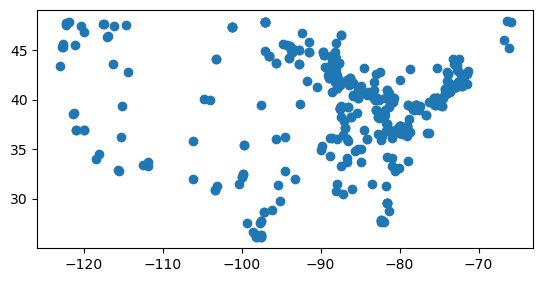

In [3]:
csv_files = list(nerc_gic.glob('*.csv'))

gic_monitors_df = pd.read_csv(csv_files[-1])
gic_monitors_df.rename(columns={" Latitude": "latitude", " Longitude": "longitude"}, inplace=True)

# Check and adjust longitude values if needed
gic_monitors_df["longitude"] = gic_monitors_df["longitude"].apply(
    lambda x: -x if x > 0 and x > 60 else x
)

# Create geometry column from Latitude and Longitude
geometry = [
    Point(xy) for xy in zip(gic_monitors_df["longitude"], gic_monitors_df["latitude"])
]

# Create GeoDataFrame
gdf_monitors = gpd.GeoDataFrame(gic_monitors_df, geometry=geometry, crs="EPSG:4326")
gdf_monitors.plot()

# Read the simulation file
gdf_mean_df = pd.read_csv(data_loc / 'gic_mean_df_1.csv')

# Make lat longitude a column
geometry = [Point(xy) for xy in zip(gdf_mean_df["longitude"], gdf_mean_df["latitude"])]
gdf_mean_sim = gpd.GeoDataFrame(gdf_mean_df, geometry=geometry, crs="EPSG:4326")

In [4]:
# Define degree-based threshold
LAT_LON_THRESHOLD = 0.05

# Find matching points
matching_sites = []

for idx_sim, sim_row in gdf_mean_sim.iterrows():
    # Find monitors within lat/lon threshold
    nearby_monitors = gdf_monitors[
        (abs(gdf_monitors["latitude"] - sim_row["latitude"]) <= LAT_LON_THRESHOLD)
        & (abs(gdf_monitors["longitude"] - sim_row["longitude"]) <= LAT_LON_THRESHOLD)
    ]

    if not nearby_monitors.empty:
        for _, monitor_row in nearby_monitors.iterrows():
            matching_sites.append(
                {
                    "substation": sim_row["sub_id"],
                    "sub_lat": sim_row["latitude"],
                    "sub_lon": sim_row["longitude"],
                    "monitor_name": monitor_row["Device ID"],
                    "monitor_lat": monitor_row["latitude"],
                    "monitor_lon": monitor_row["longitude"],
                }
            )

# Create DataFrame of matches
matches_df = pd.DataFrame(matching_sites)

# Drop duplicates
matches_df.drop_duplicates(subset=["substation", "monitor_name"], inplace=True)
matches_df

substation    sub_lat     sub_lon  monitor_name  monitor_lat  \
0        9094967  45.542823  -94.274360         10348         45.5   
4       10390117  39.022102  -83.009678         10483         39.0   
5       10390117  39.022102  -83.009678         10484         39.0   
6       10390117  39.022102  -83.009678         10485         39.0   
16      10390118  40.718566  -81.416346         10563         40.7   
...          ...        ...         ...           ...          ...   
1372  1072135234  40.100424 -104.772866         10637         40.1   
1376  1111901665  35.377151  -99.719740         10463         35.4   
1377  1111901665  35.377151  -99.719740         10464         35.4   
1384  1194159493  41.892532  -86.201415         10511         41.9   
1388  1210590700  36.046612  -86.605734         10212         36.0   

      monitor_lon  
0           -94.3  
4           -83.0  
5           -83.0  
6           -83.0  
16          -81.4  
...           ...  
1372       -104.8  
1376        -99.7  
1377        -99.7  
1384        -86.2  
1388        -86.6  

[348 rows x 6 columns]

In [5]:
print(
    f"Found {len(matches_df)} pairs of simulation-monitor sites within approximately 100 meters:"
)
print(matches_df)

Found 348 pairs of simulation-monitor sites within approximately 100 meters:
      substation    sub_lat     sub_lon  monitor_name  monitor_lat  \
0        9094967  45.542823  -94.274360         10348         45.5   
4       10390117  39.022102  -83.009678         10483         39.0   
5       10390117  39.022102  -83.009678         10484         39.0   
6       10390117  39.022102  -83.009678         10485         39.0   
16      10390118  40.718566  -81.416346         10563         40.7   
...          ...        ...         ...           ...          ...   
1372  1072135234  40.100424 -104.772866         10637         40.1   
1376  1111901665  35.377151  -99.719740         10463         35.4   
1377  1111901665  35.377151  -99.719740         10464         35.4   
1384  1194159493  41.892532  -86.201415         10511         41.9   
1388  1210590700  36.046612  -86.605734         10212         36.0   

      monitor_lon  
0           -94.3  
4           -83.0  
5           -83.0  
6 

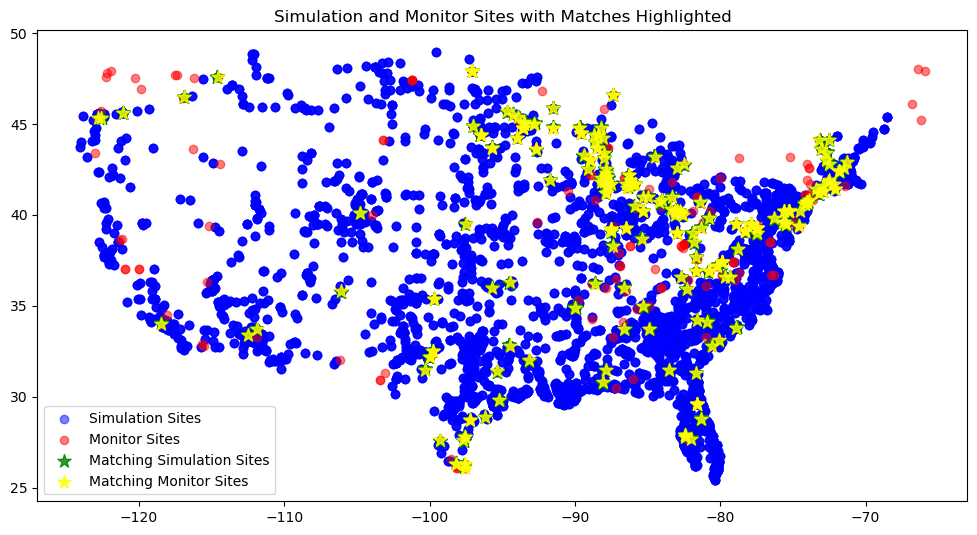

In [6]:
# Visualize the matches
fig, ax = plt.subplots(figsize=(12, 8))

# Plot all simulation points
gdf_mean_sim.plot(ax=ax, color="blue", alpha=0.5, label="Simulation Sites")

# Plot all monitor points
gdf_monitors.plot(ax=ax, color="red", alpha=0.5, label="Monitor Sites")

# Highlight matching points
if len(matches_df) > 0:
    matching_sim_sites = gdf_mean_sim[
        gdf_mean_sim["sub_id"].isin(matches_df["substation"])
    ]
    matching_monitor_sites = gdf_monitors[
        gdf_monitors["Device ID"].isin(matches_df["monitor_name"])
    ]

    matching_sim_sites.plot(
        ax=ax,
        color="green",
        alpha=0.8,
        marker="*",
        markersize=100,
        label="Matching Simulation Sites",
    )
    matching_monitor_sites.plot(
        ax=ax,
        color="yellow",
        alpha=0.8,
        marker="*",
        markersize=100,
        label="Matching Monitor Sites",
    )

plt.title("Simulation and Monitor Sites with Matches Highlighted")
plt.legend()
plt.show()

In [7]:
if os.path.exists(data_loc / "nerc_gic.nc"):
    ds = xr.open_dataset(data_loc / "nerc_gic.nc")

else:
    device_data = {}
    timestamps_set = set()

    # Step 1: Read files and store data per device
    for file in nerc_files:
        df = pd.read_csv(file)
        df["SampleDateTime"] = pd.to_datetime(
            df["SampleDateTime"], format="%m/%d/%Y %I:%M:%S %p", errors="coerce"
        )

        for device_id, group in df.groupby("GICDeviceID"):
            if device_id not in device_data:
                device_data[device_id] = {}

            timestamps_set.update(group["SampleDateTime"])
            device_data[device_id].update(
                dict(zip(group["SampleDateTime"], group["GICMeasured"]))
            )

    # Step 2: Create a uniform time index
    timestamps = sorted(timestamps_set)

    # Step 3: Convert data to a 2D array (time x device), filling missing values with NaN
    device_ids = sorted(device_data.keys())
    data_array = np.full((len(timestamps), len(device_ids)), np.nan)

    for j, device_id in enumerate(device_ids):
        for i, timestamp in enumerate(timestamps):
            if timestamp in device_data[device_id]:
                data_array[i, j] = device_data[device_id][timestamp]

    # Step 4: Create an Xarray Dataset
    ds = xr.Dataset(
        data_vars={"gic": (["time", "device"], data_array)},
        coords={"time": timestamps, "device": device_ids},
    )

    ## Add metadata
    # Step 5: Add metadata from `gic_monitors_df`
    metadata_cols = [
        "latitude",
        "longitude",
        " Installation Type",
        " Connection",
        " Minimum Value in Measurement Range",
    ]

    gic_monitors_dict = gic_monitors_df.set_index("Device ID").to_dict()

    for col in metadata_cols:
        ds = ds.assign_coords(
            {
                col.lower().replace(" ", "_"): (
                    "device",
                    [gic_monitors_dict[col].get(d, np.nan) for d in device_ids],
                )
            }
        )

    # Save the xarray dataset to a NetCDF file
    ds.to_netcdf(data_loc / "nerc_gic.nc")

In [8]:
# Read the magnetic data
nerc_mag_folder = data_loc / 'nerc' / 'mag'

# glob files if start with 2024*.csv
mag_files = list(nerc_mag_folder.glob('2024*.csv'))

# Read magnetic data locs
mag_locs_df = pd.read_csv(nerc_mag_folder / "magnetometers.csv")

# Rename columns removing white spaces
mag_locs_df.rename(
    columns={
        "Device ID": "device_id",
        " Latitude": "latitude",
        " Longitude": "longitude",
        " Orientation": "orientation",
    },
    inplace=True,
)

# Filtere only geographic orientation
# Filter out only geographic coordinates
mag_locs_df = mag_locs_df[mag_locs_df["orientation"] == "1 - Geographic"].copy()

# Since in US, longitude is negative, we need to adjust
mag_locs_df["longitude"] = mag_locs_df["longitude"].apply(
    lambda x: -x if x > 0 and x > 60 else x
)

# Some orientations are geographic while others are geomagnetic
df_list = [pd.read_csv(f) for f in mag_files]
mag_df = pd.concat(df_list, ignore_index=True)

# Rename columns for consistency
mag_df.rename(
    columns={
        "MagnetometerDeviceID": "device_id",
        "SampleDateTime": "time",
        "GeoBfieldMeasureNorth": "B_North",
        "GeoBfieldMeasureEast": "B_East",
        "GeoBfieldMeasureVertical": "B_Vertical",
    },
    inplace=True,
)

In [9]:
# Convert time column to datetime format
mag_df["time"] = pd.to_datetime(mag_df["time"], format="%m/%d/%Y %I:%M:%S %p")

# Merge with magnetometer locations data to get latitude, longitude, and orientation
mag_df = mag_df.merge(mag_locs_df, on="device_id", how="inner")

# %%
# Convert to xarray Dataset
ds_mag = xr.Dataset(
    {
        "B_North": (
            ["time", "device"],
            mag_df.pivot(index="time", columns="device_id", values="B_North").values,
        ),
        "B_East": (
            ["time", "device"],
            mag_df.pivot(index="time", columns="device_id", values="B_East").values,
        ),
        "B_Vertical": (
            ["time", "device"],
            mag_df.pivot(index="time", columns="device_id", values="B_Vertical").values,
        ),
    },
    coords={
        "time": mag_df["time"].unique(),
        "device": mag_df["device_id"].unique(),
        "latitude": (
            ["device"],
            mag_df.drop_duplicates("device_id")
            .set_index("device_id")["latitude"]
            .values,
        ),
        "longitude": (
            ["device"],
            mag_df.drop_duplicates("device_id")
            .set_index("device_id")["longitude"]
            .values,
        ),
        "orientation": (
            ["device"],
            mag_df.drop_duplicates("device_id")
            .set_index("device_id")["orientation"]
            .values,
        ),
    },
)

In [10]:
# Function to detrend and handle missing values
def preprocess_magnetic_field(ds):
    for comp in ["B_North", "B_East", "B_Vertical"]:
        if comp in ds:
            # Fill missing values with backward fill and interpolation
            ds[comp] = ds[comp].bfill(dim="time").interpolate_na(dim="time")

            # Detrend the data
            ds[comp] = xr.DataArray(
                scipy.signal.detrend(ds[comp], axis=0),
                dims=ds[comp].dims,
                coords=ds[comp].coords,
            )

    return ds

# Apply preprocessing
ds_mag = preprocess_magnetic_field(ds_mag)

# Save to NetCDF file
ds_mag.to_netcdf(data_loc / "nerc_magnetometer_data.nc")

# Read the magnetotelluric data from secs and bezpy
magnetotelluric_ds = xr.open_dataset(data_loc / "ds_gannon.nc")

In [11]:
# Find mt sites within 0.01 degrees of the monitor sites
threshold = 0.2

# Extract MT site coordinates
mt_lats = magnetotelluric_ds.site_x.values
mt_lons = magnetotelluric_ds.site_y.values
mt_names = magnetotelluric_ds.name.values

# Extract magnetometer station coordinates
gic_lats = ds_mag.latitude.values
gic_lons = ds_mag.longitude.values

# Find closest MT sites for each GIC station within the threshold
closest_mt_sites = []
for gic_lat, gic_lon in zip(gic_lats, gic_lons):
    mask = (np.abs(mt_lats - gic_lat) <= threshold) & (
        np.abs(mt_lons - gic_lon) <= threshold
    )
    matching_sites = np.where(mask)[0]

    # Store the first match or NaN if no match found
    closest_mt_sites.append(matching_sites[0] if matching_sites.size > 0 else np.nan)

ds_mag = ds_mag.assign_coords(nearest_mt_site=("device", closest_mt_sites))

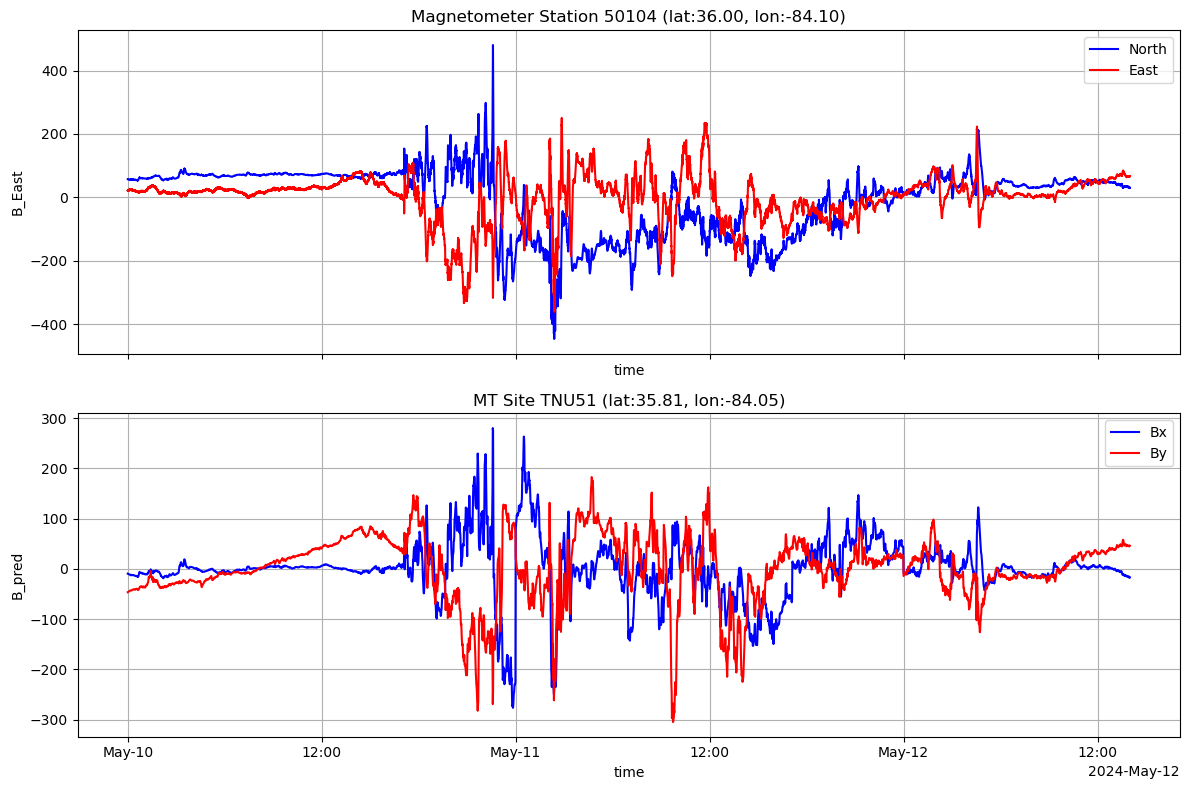

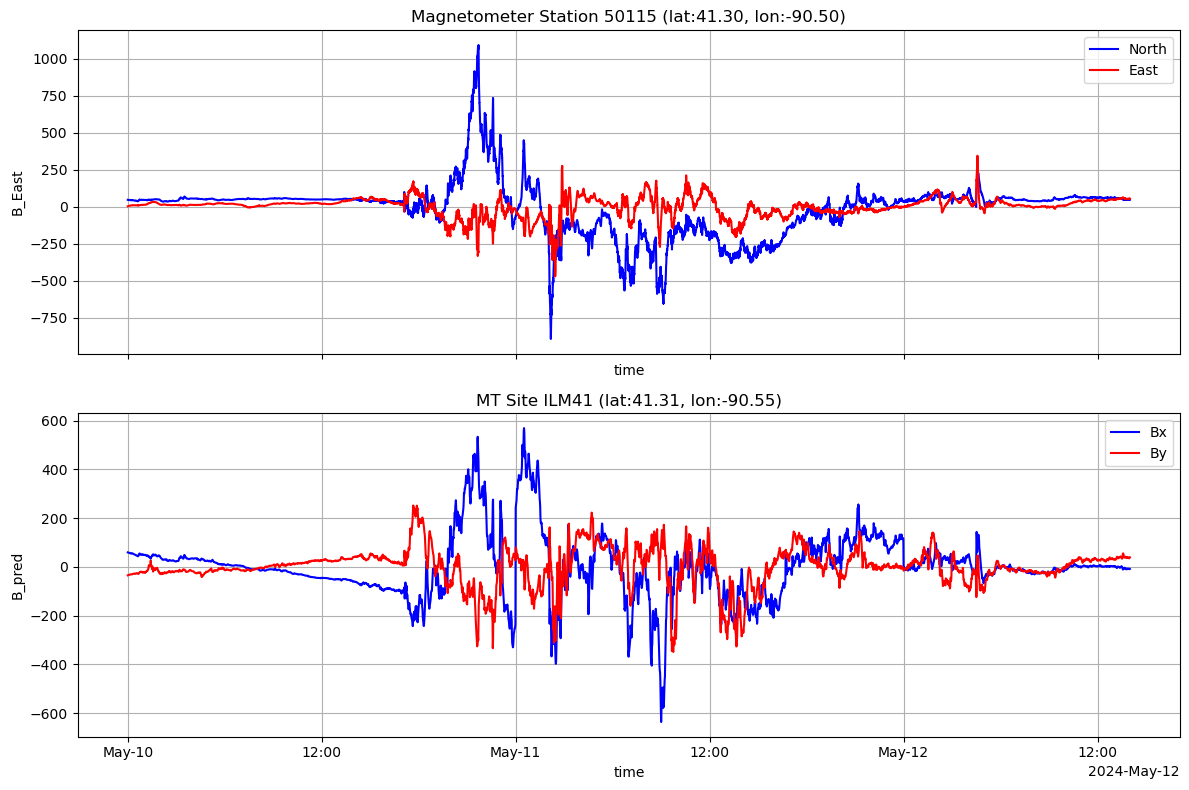

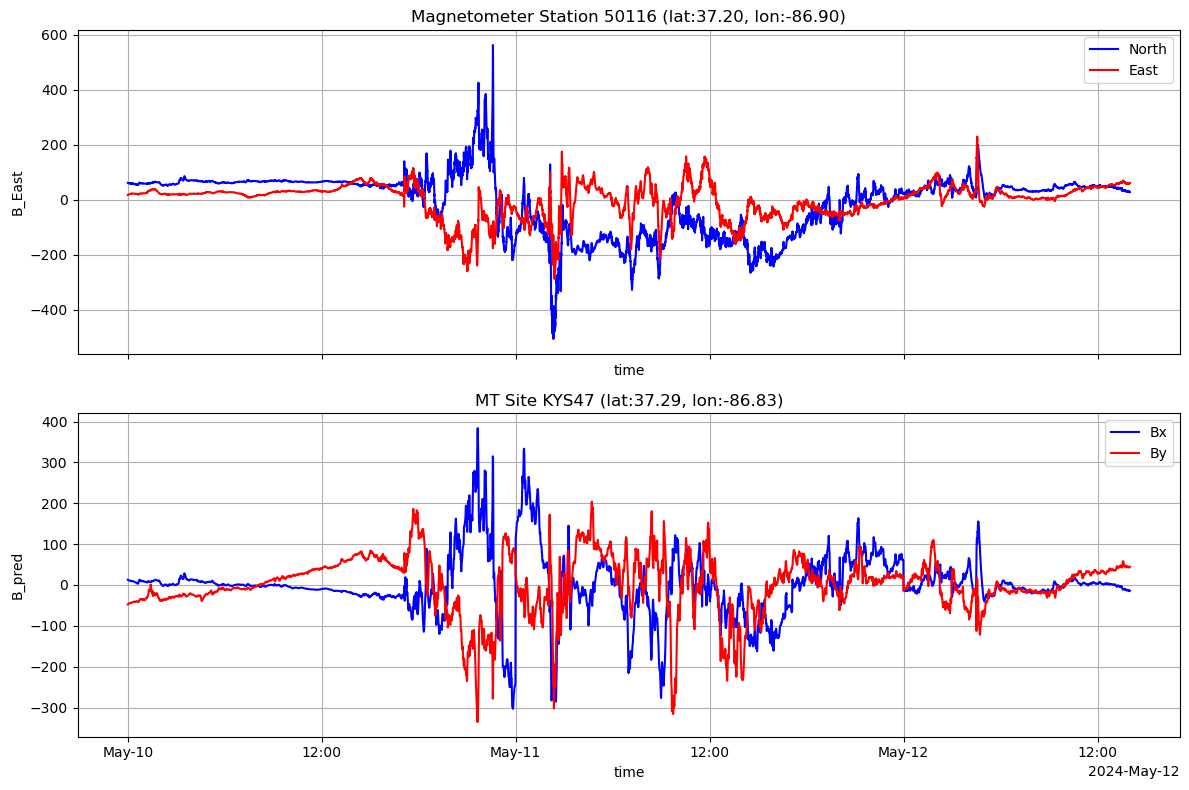

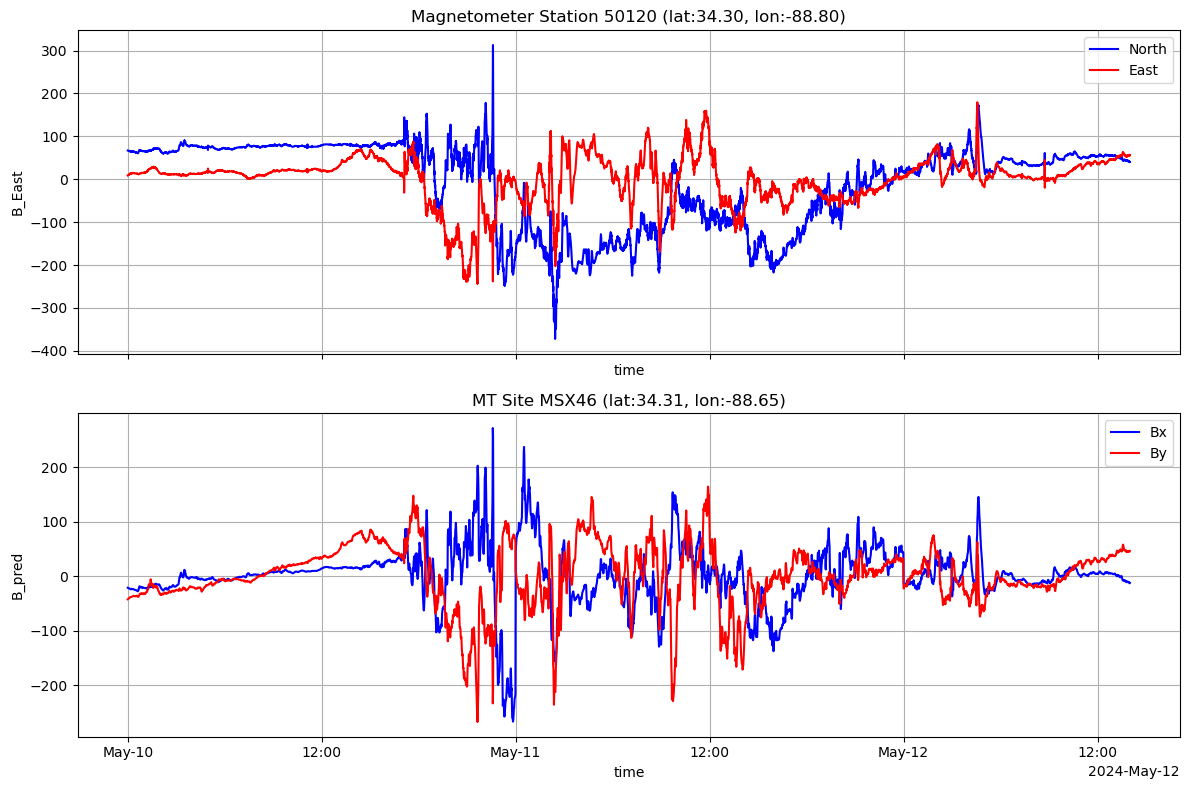

In [12]:
# First find common time range
mag_time_range = ds_mag.time.values
mt_time_range = magnetotelluric_ds.time.values

# Find overlap
start_time = max(mag_time_range[0], mt_time_range[0])
end_time = min(mag_time_range[-1], mt_time_range[-1])

# Slice both datasets to common time range
ds_mag_sliced = ds_mag.sel(time=slice(start_time, end_time))
ds_mt_sliced = magnetotelluric_ds.sel(time=slice(start_time, end_time))

# Define colors
north_color = "blue"
east_color = "red"

# Plot for each matching pair
# Get location info and names
mag_stations_with_mt = ds_mag.device.values[~np.isnan(ds_mag.nearest_mt_site.values)]
mt_indices = ds_mag.nearest_mt_site.values[~np.isnan(ds_mag.nearest_mt_site.values)]

for mag_station, mt_idx in zip(mag_stations_with_mt, mt_indices):
    mt_idx = int(mt_idx)

    mag_lat = ds_mag.latitude.sel(device=mag_station).values
    mag_lon = ds_mag.longitude.sel(device=mag_station).values
    mt_lat = magnetotelluric_ds.site_x.isel(site_x=mt_idx).values
    mt_lon = magnetotelluric_ds.site_y.isel(site_y=mt_idx).values
    mt_name = mt_names[mt_idx]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Plot magnetometer data
    ds_mag_sliced.B_North.sel(device=mag_station).plot(
        ax=ax1, label="North", color=north_color
    )
    ds_mag_sliced.B_East.sel(device=mag_station).plot(
        ax=ax1, label="East", color=east_color
    )
    ax1.set_title(
        f"Magnetometer Station {mag_station} (lat:{mag_lat:.2f}, lon:{mag_lon:.2f})"
    )
    ax1.legend()
    ax1.grid(True)

    # Plot MT site data
    ds_mt_sliced.B_pred.sel(site=mt_idx, component="Bx").plot(
        ax=ax2, label="Bx", color=north_color
    )
    ds_mt_sliced.B_pred.sel(site=mt_idx, component="By").plot(
        ax=ax2, label="By", color=east_color
    )
    ax2.set_title(f"MT Site {mt_name} (lat:{mt_lat:.2f}, lon:{mt_lon:.2f})")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [13]:
# E_pred = magnetotelluric_ds.E_pred.values

# # Storm peaks
# e_pred_peak_data = find_storm_maximum(
#     E_pred, window_hours=(20 / 60)
# )  # Every 20 minutes for thermal heating
# peak_time = e_pred_peak_data["optimal_time"]
# e_pred_peak = E_pred[peak_time, :, :]

# e_pred_magnitude = np.sqrt(np.sum(e_pred_peak**2, axis=1))

# # peak time stamp
# peak_time_stamp = magnetotelluric_ds.time.values[peak_time]

# # Extract the peak gic values
# gic_peak = ds.gic.sel(time=peak_time_stamp).values

In [14]:
# Read recursively the ground gic sensitivity dfs
ground_gic_folder = data_loc / "ground_gic"
gnd_files = list(ground_gic_folder.glob("*.csv"))

pd.read_csv(gnd_files[0])

peak_times = np.load('peak_times.npy')

In [15]:
# Load all CSVs into a 3D NumPy array (Simulations, Substations, Time Steps)
data_list = [pd.read_csv(file).iloc[:, 1:].values for file in gnd_files]  # Exclude 'Substation' column
data_array = np.stack(data_list, axis=0)  # Shape: (num_simulations, num_substations, num_timesteps)

print(data_array.shape) 

(664, 3681, 20)


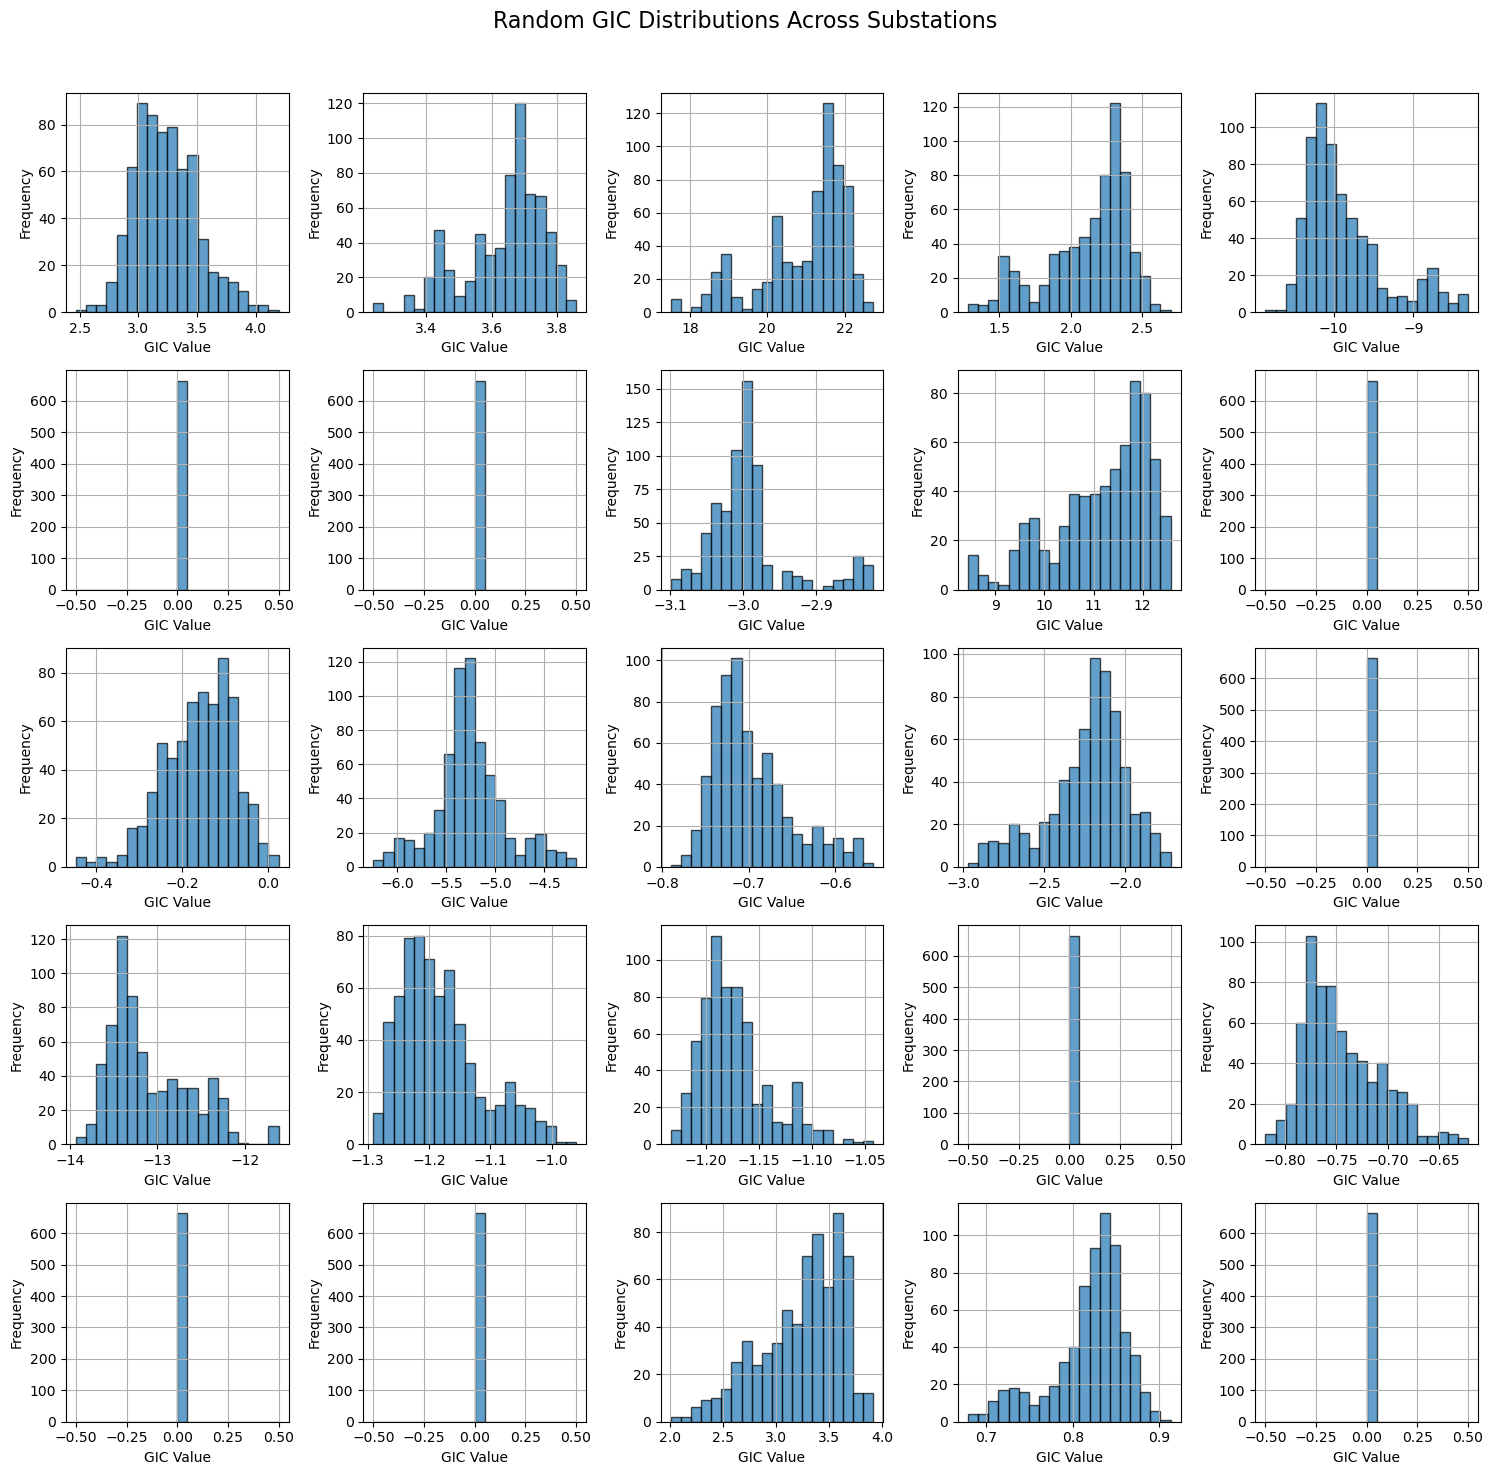

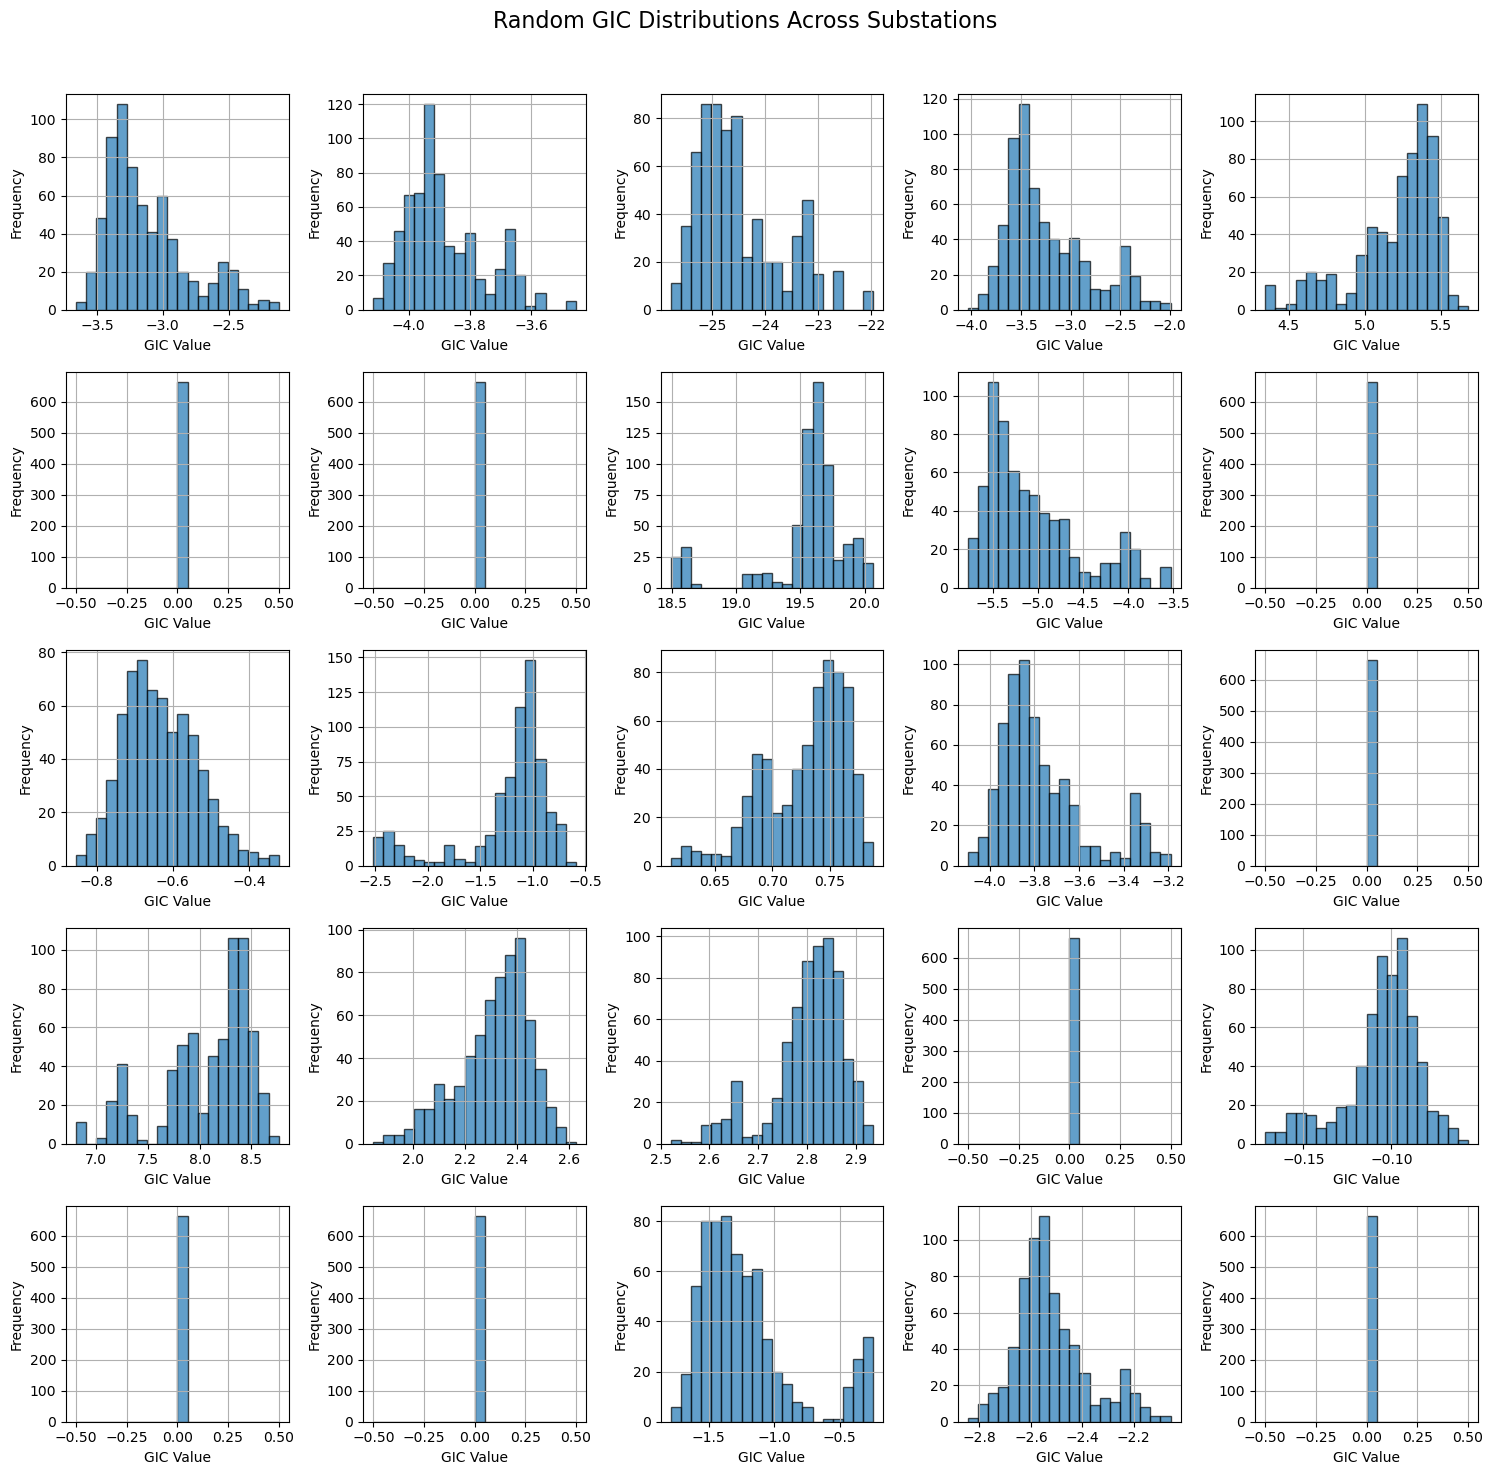

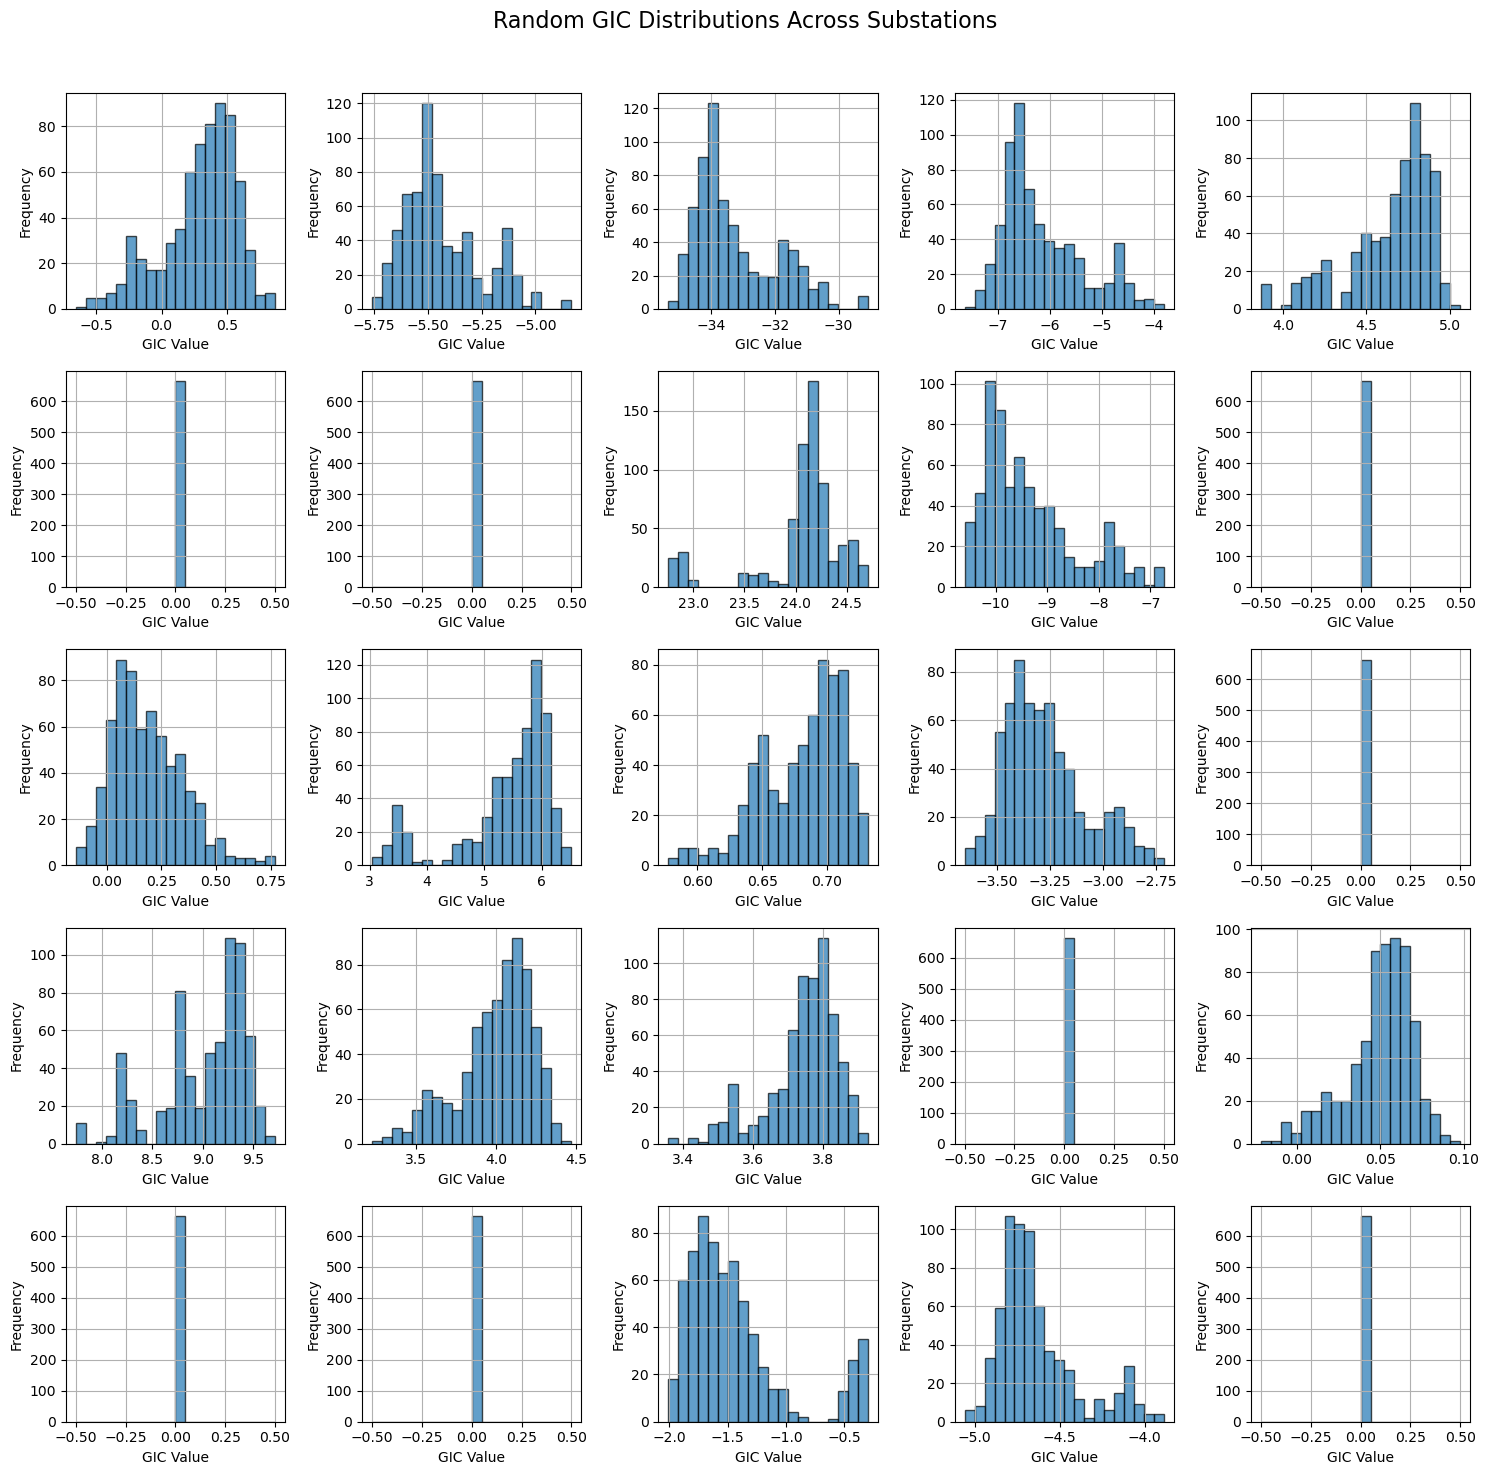

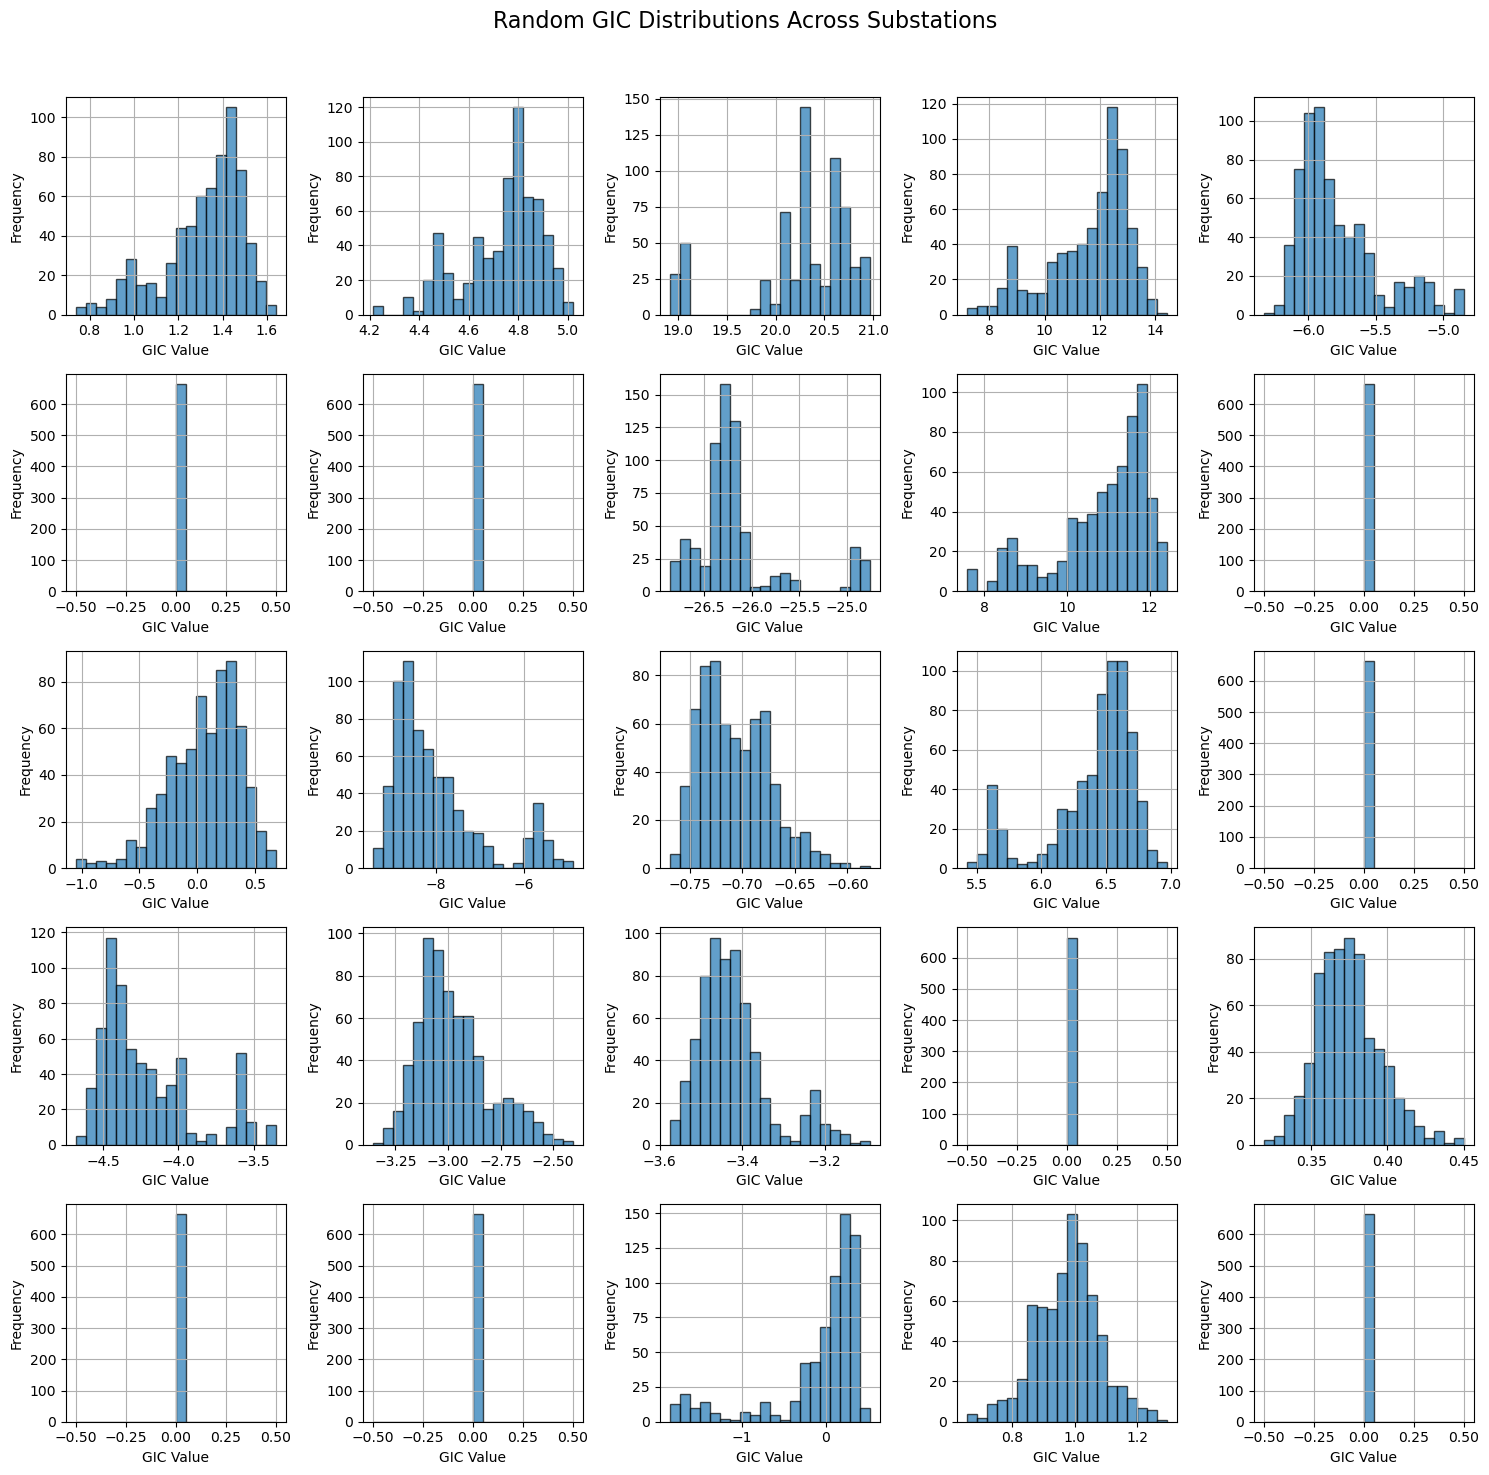

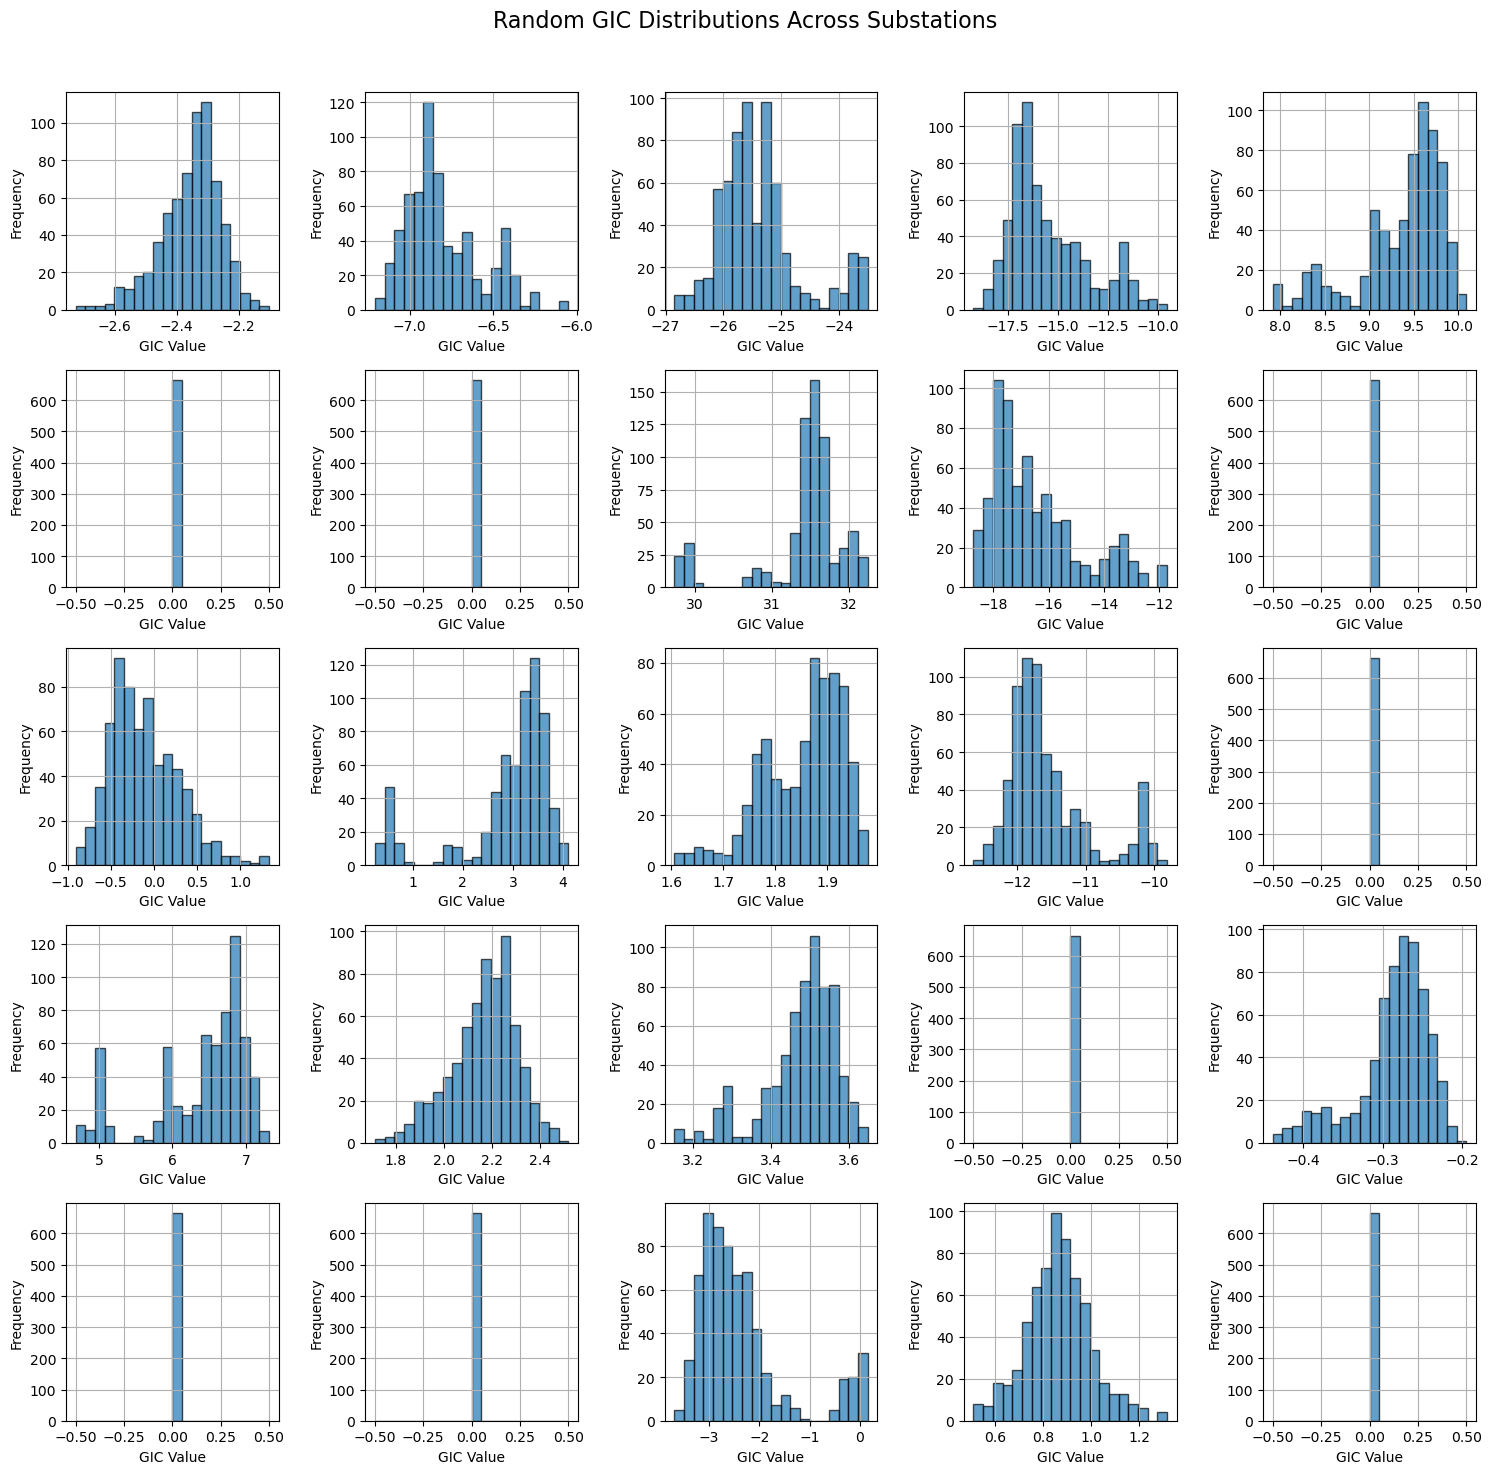

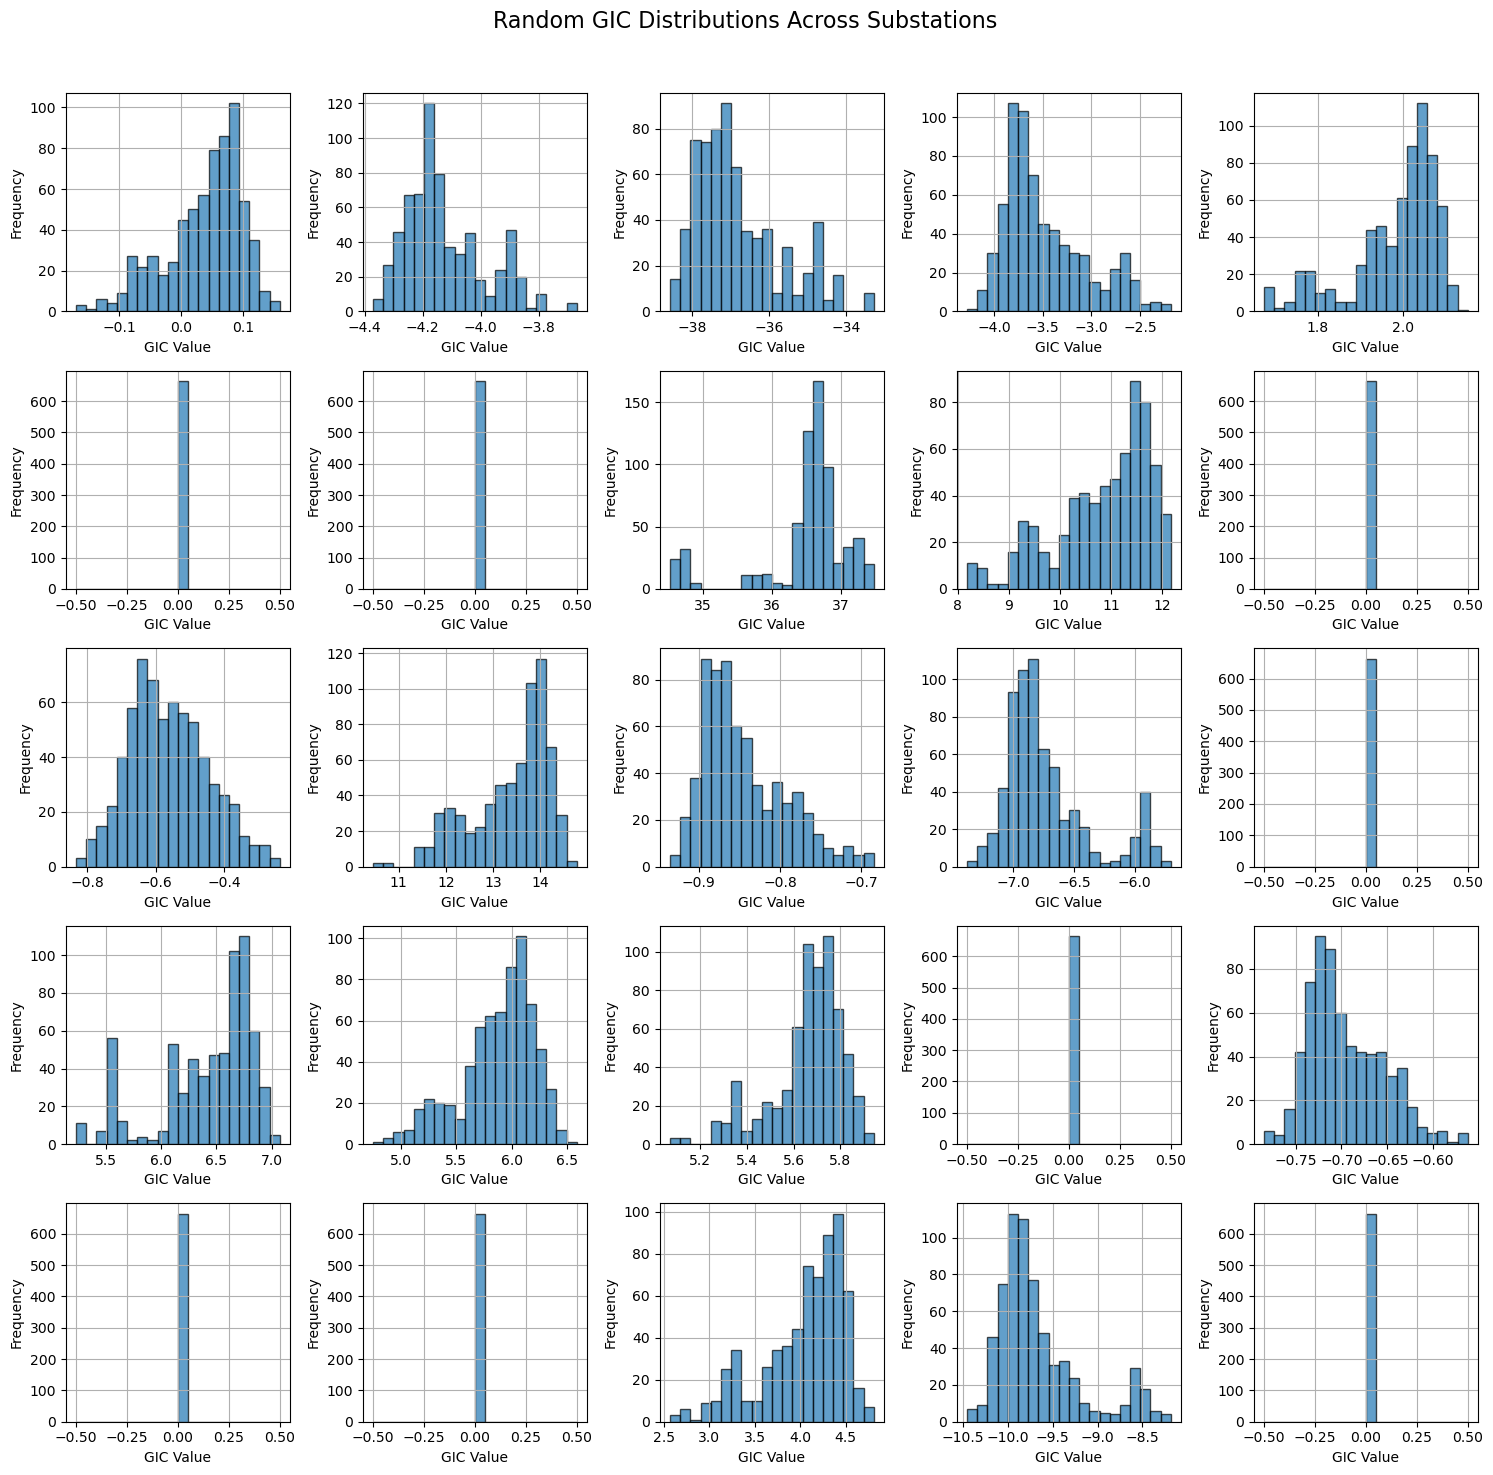

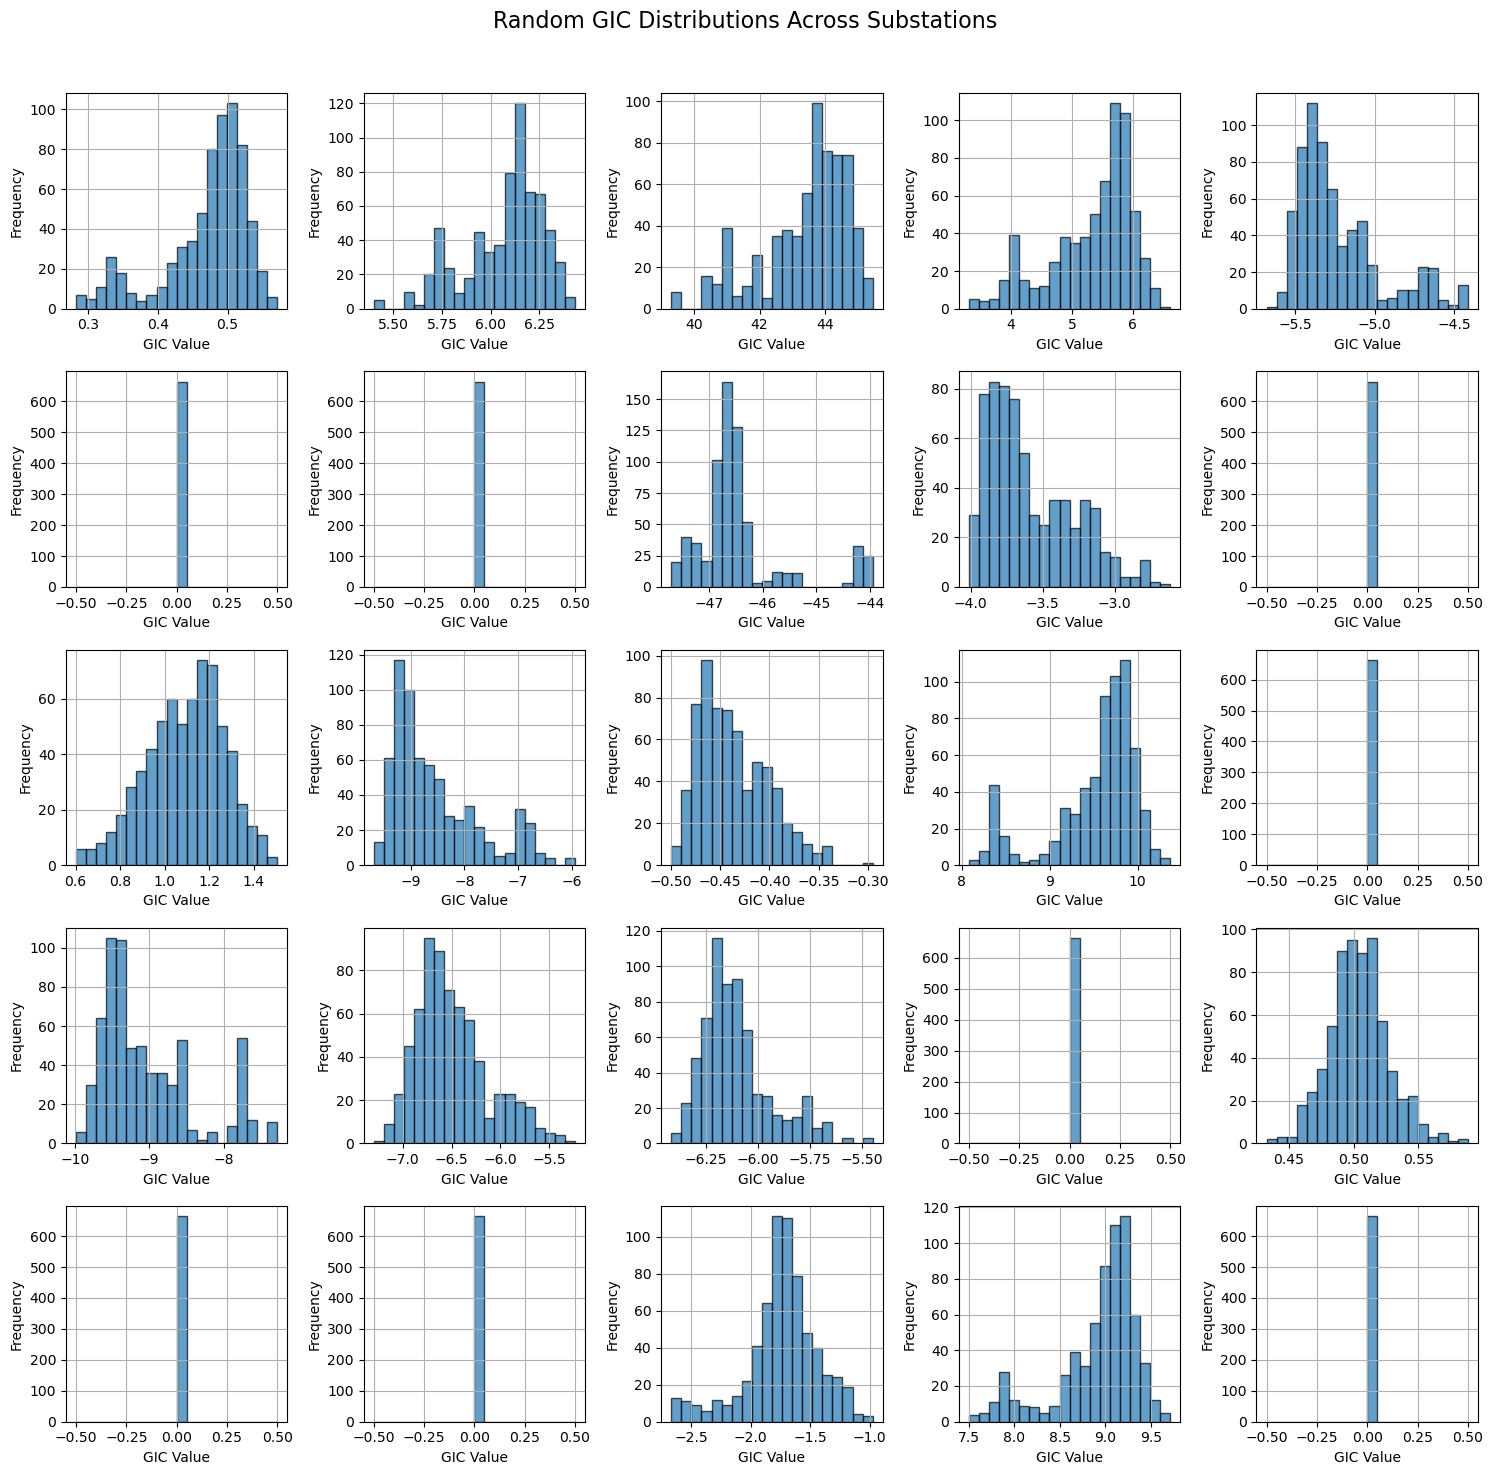

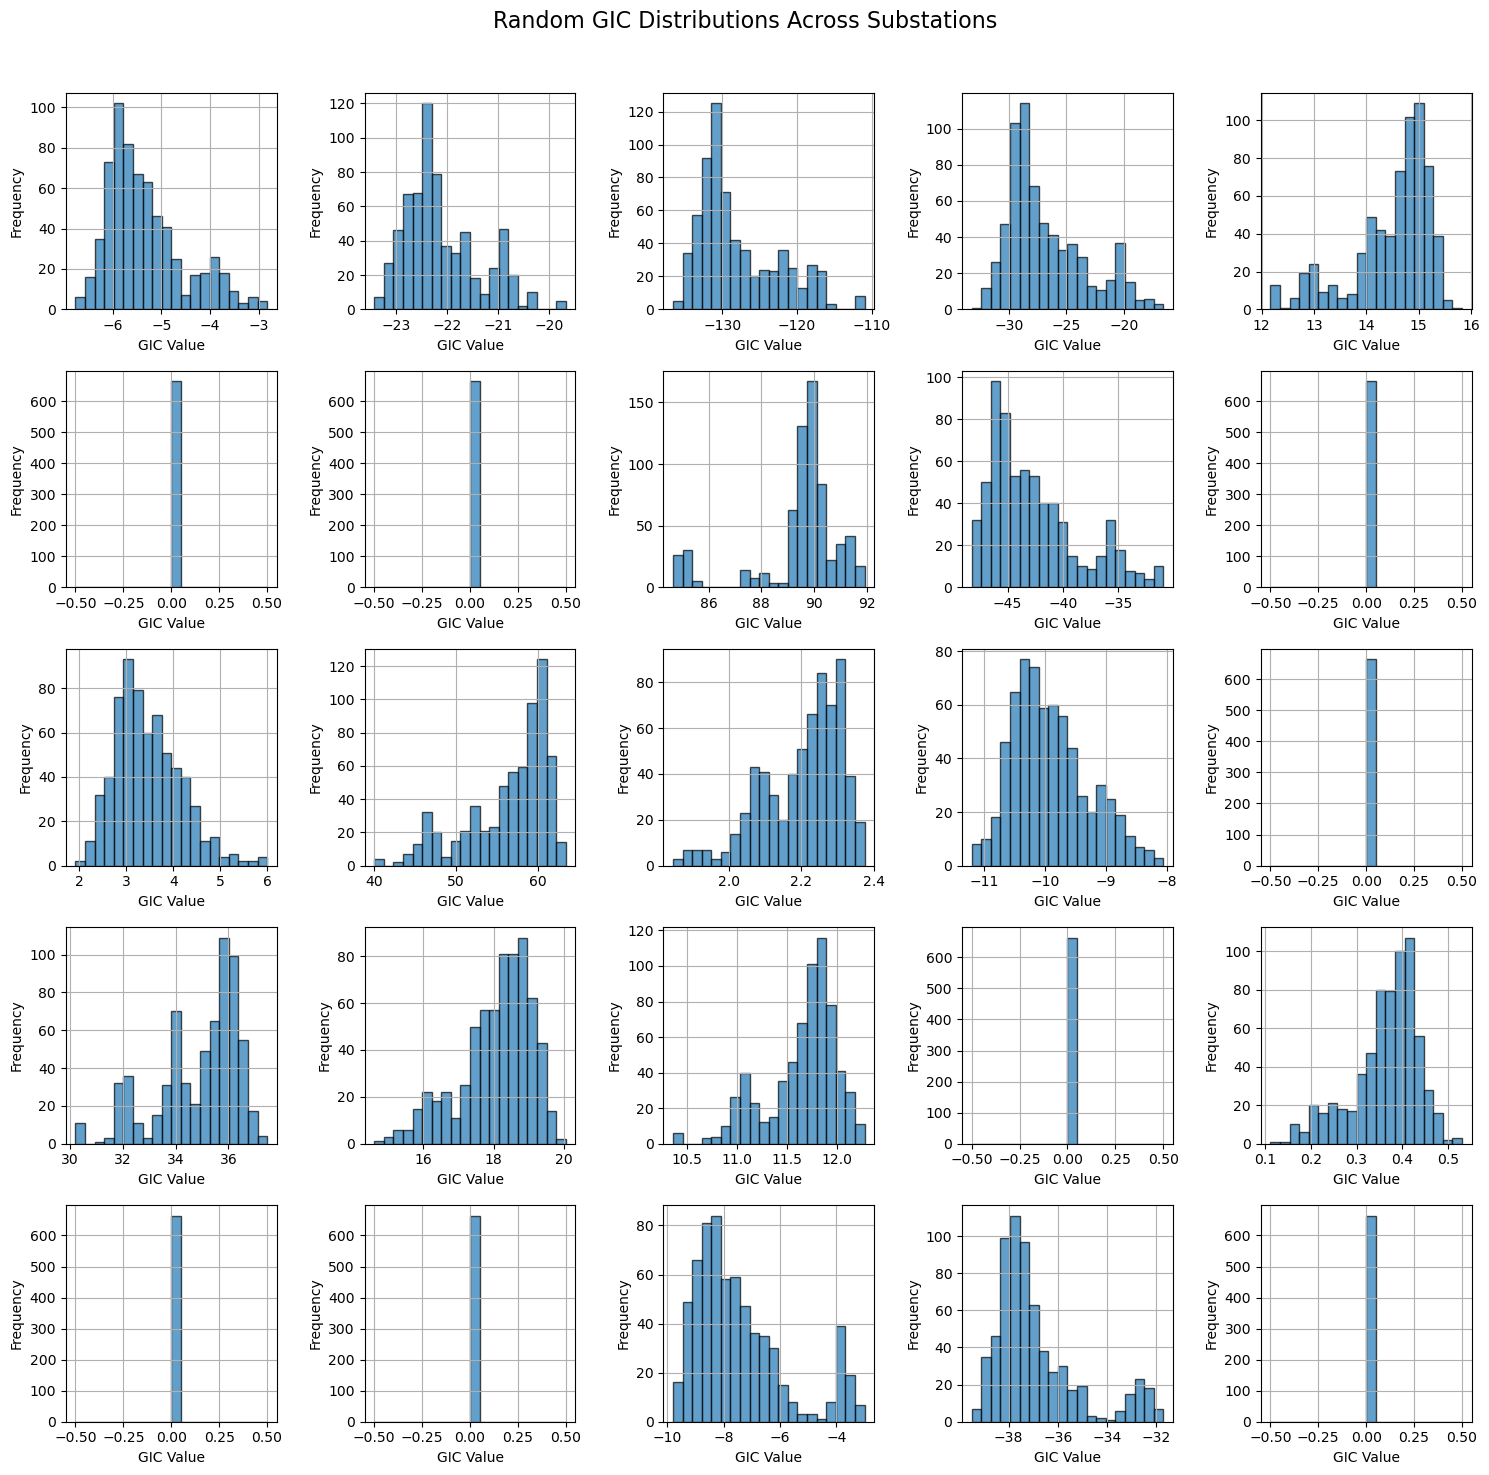

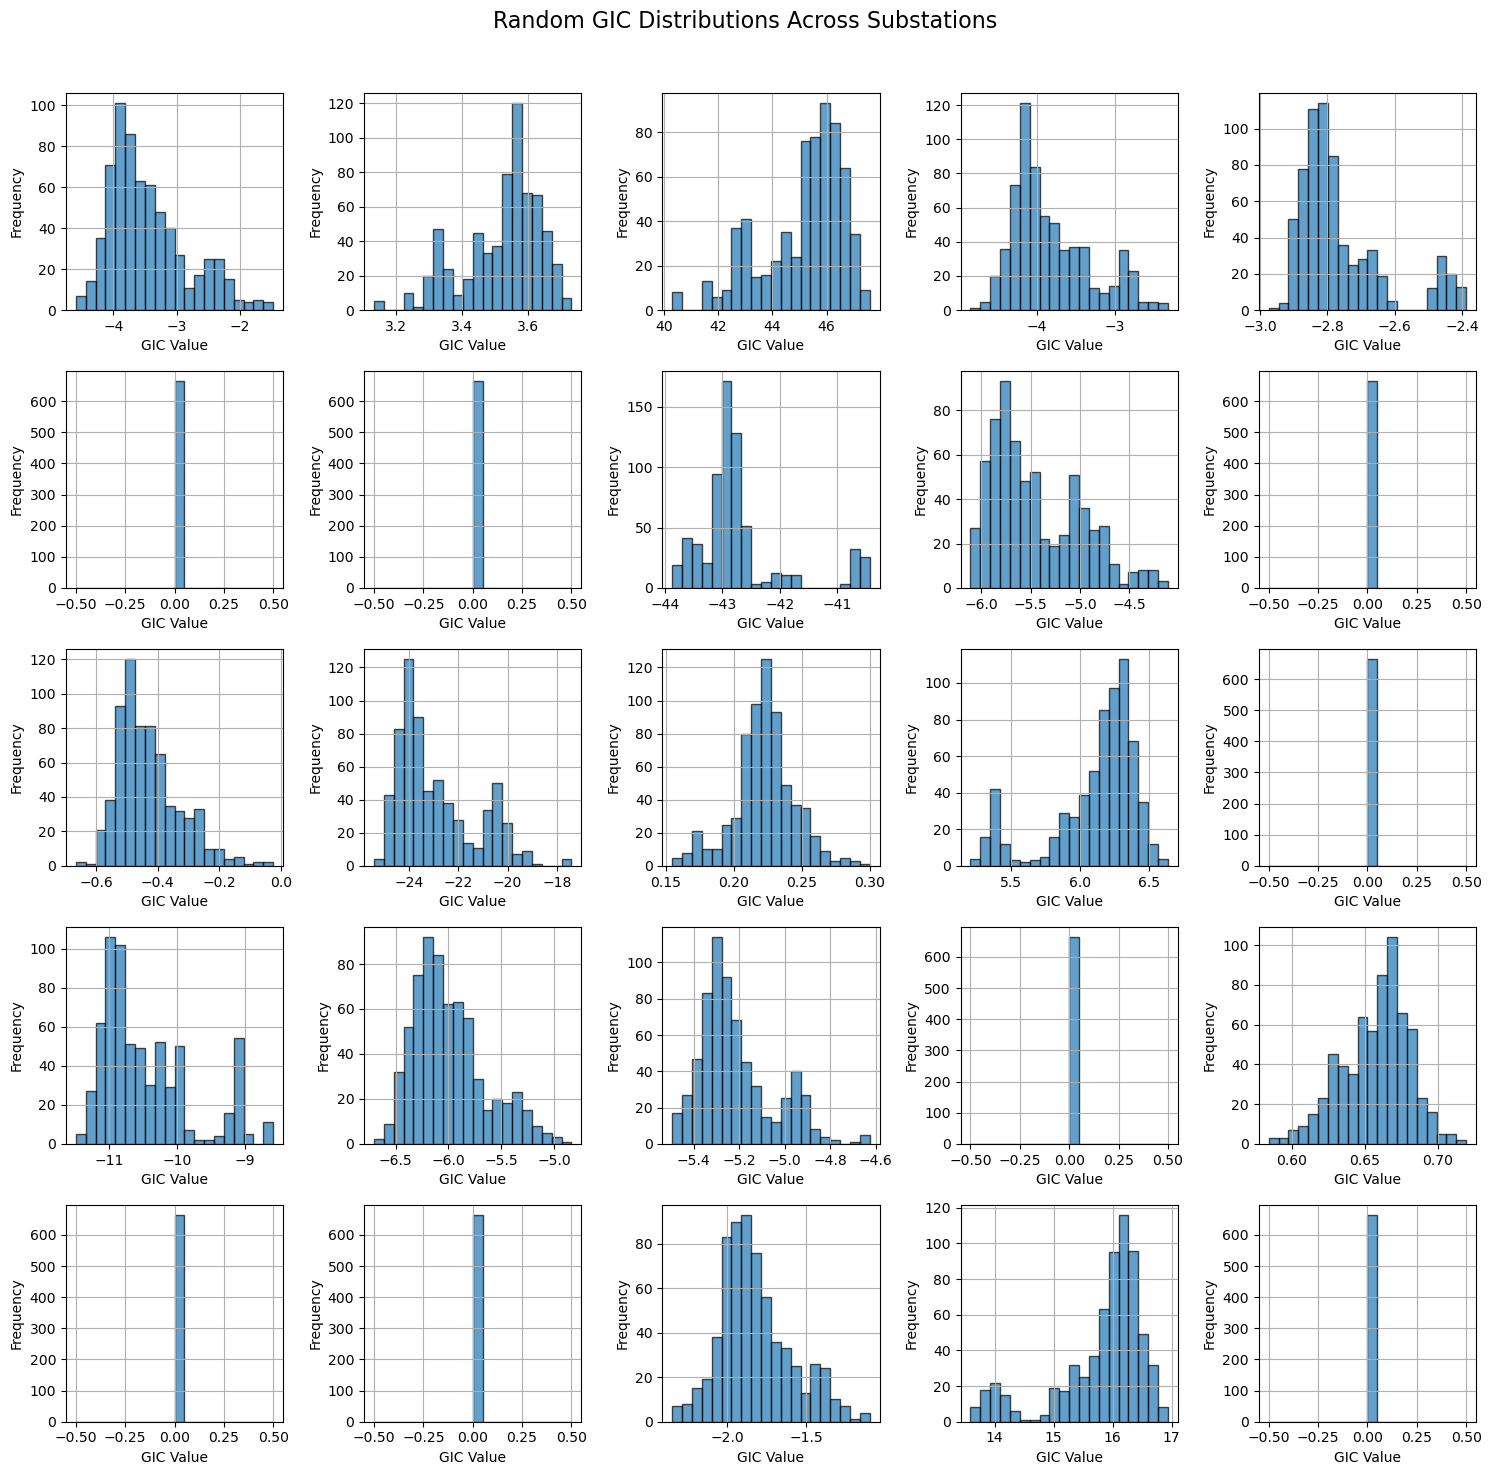

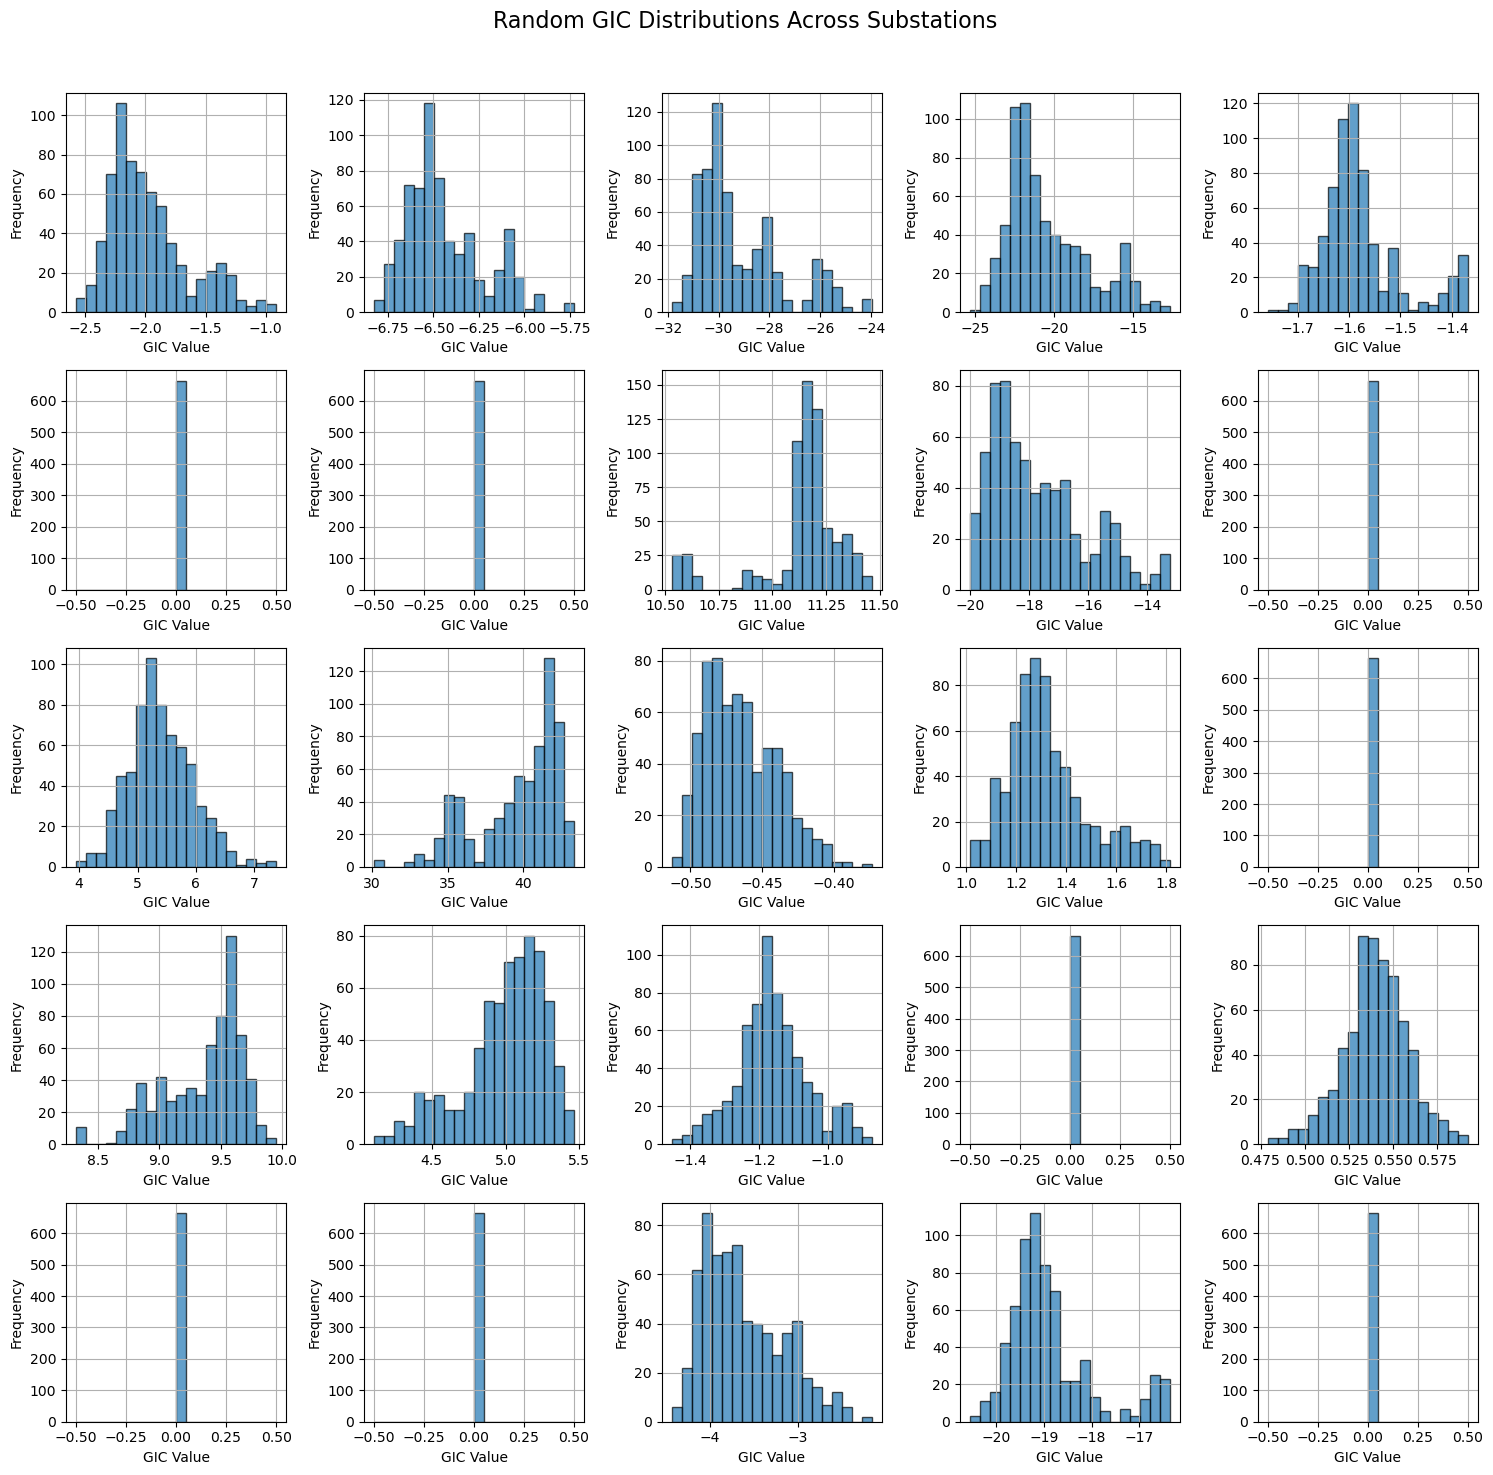

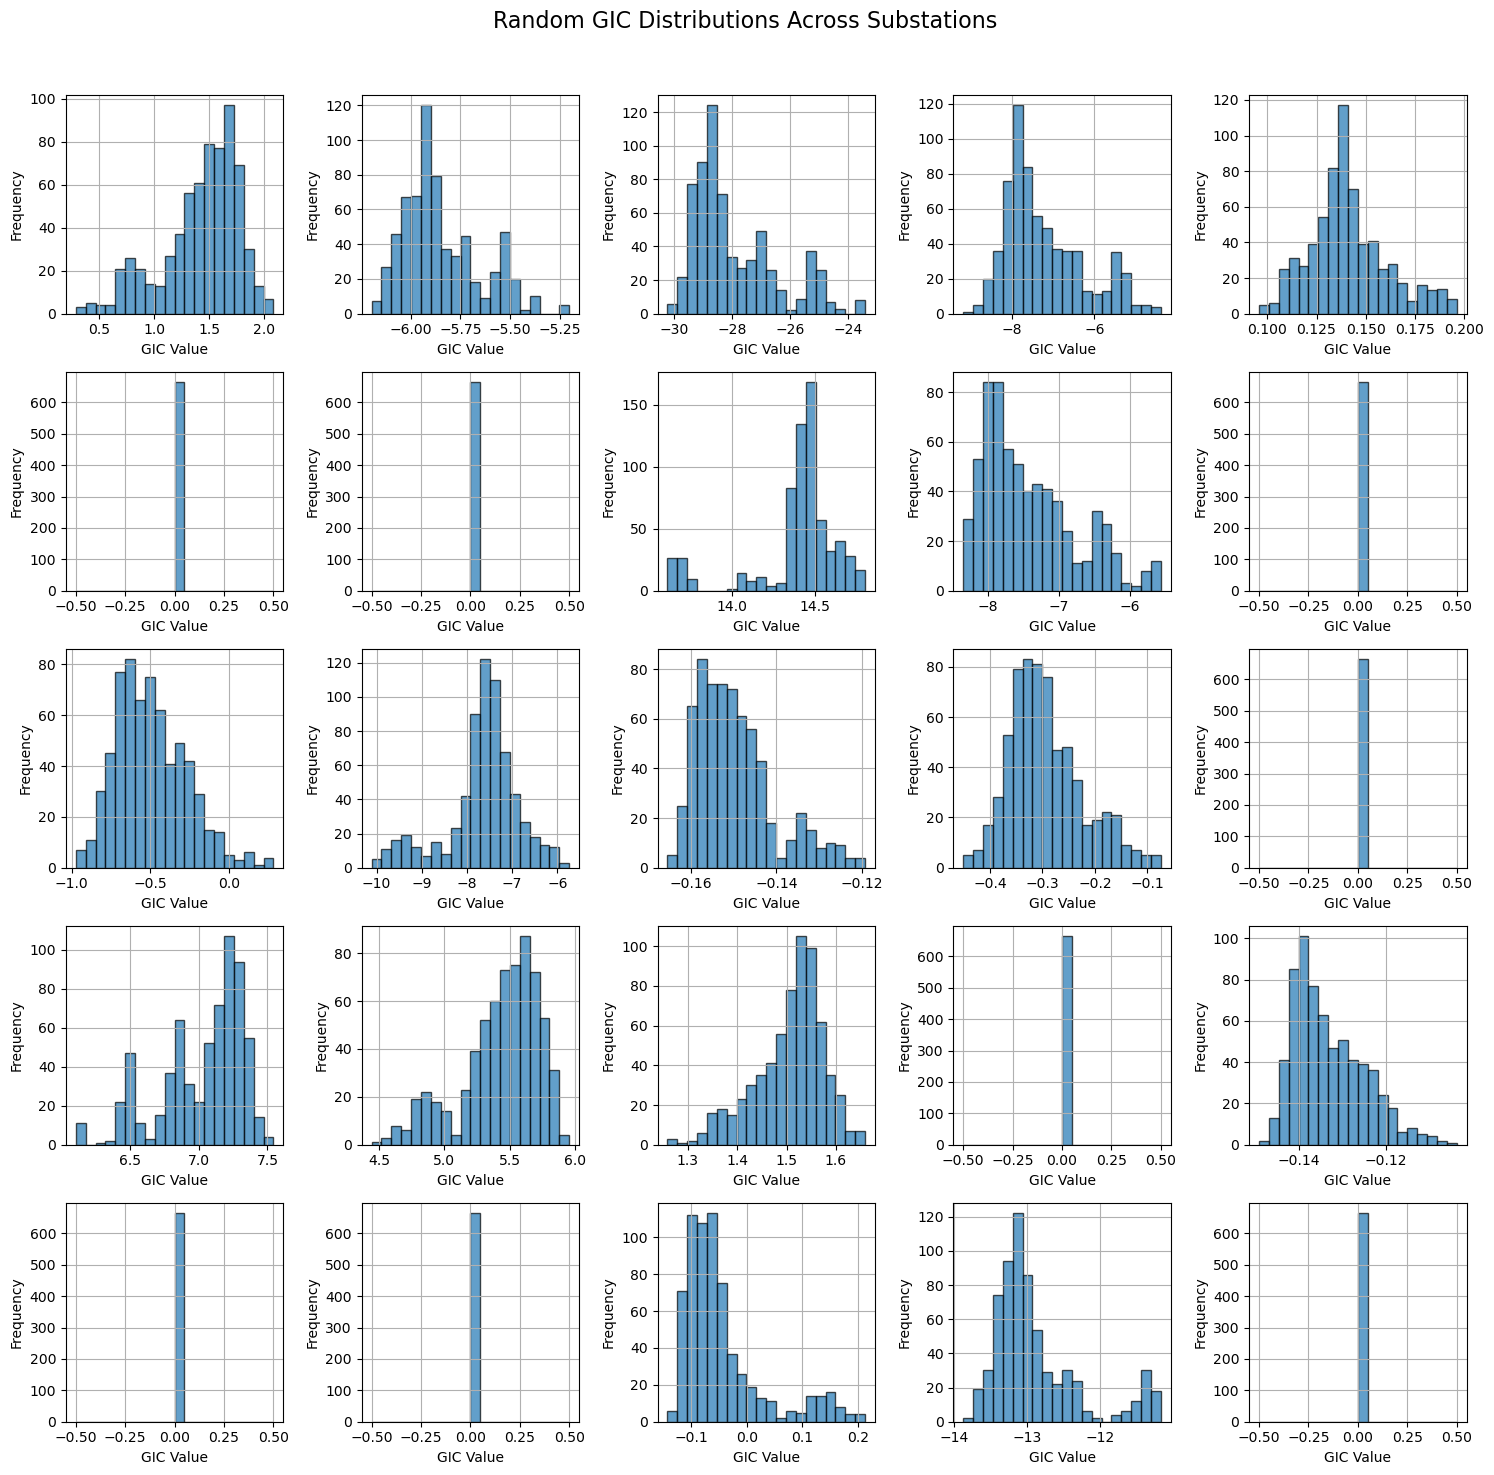

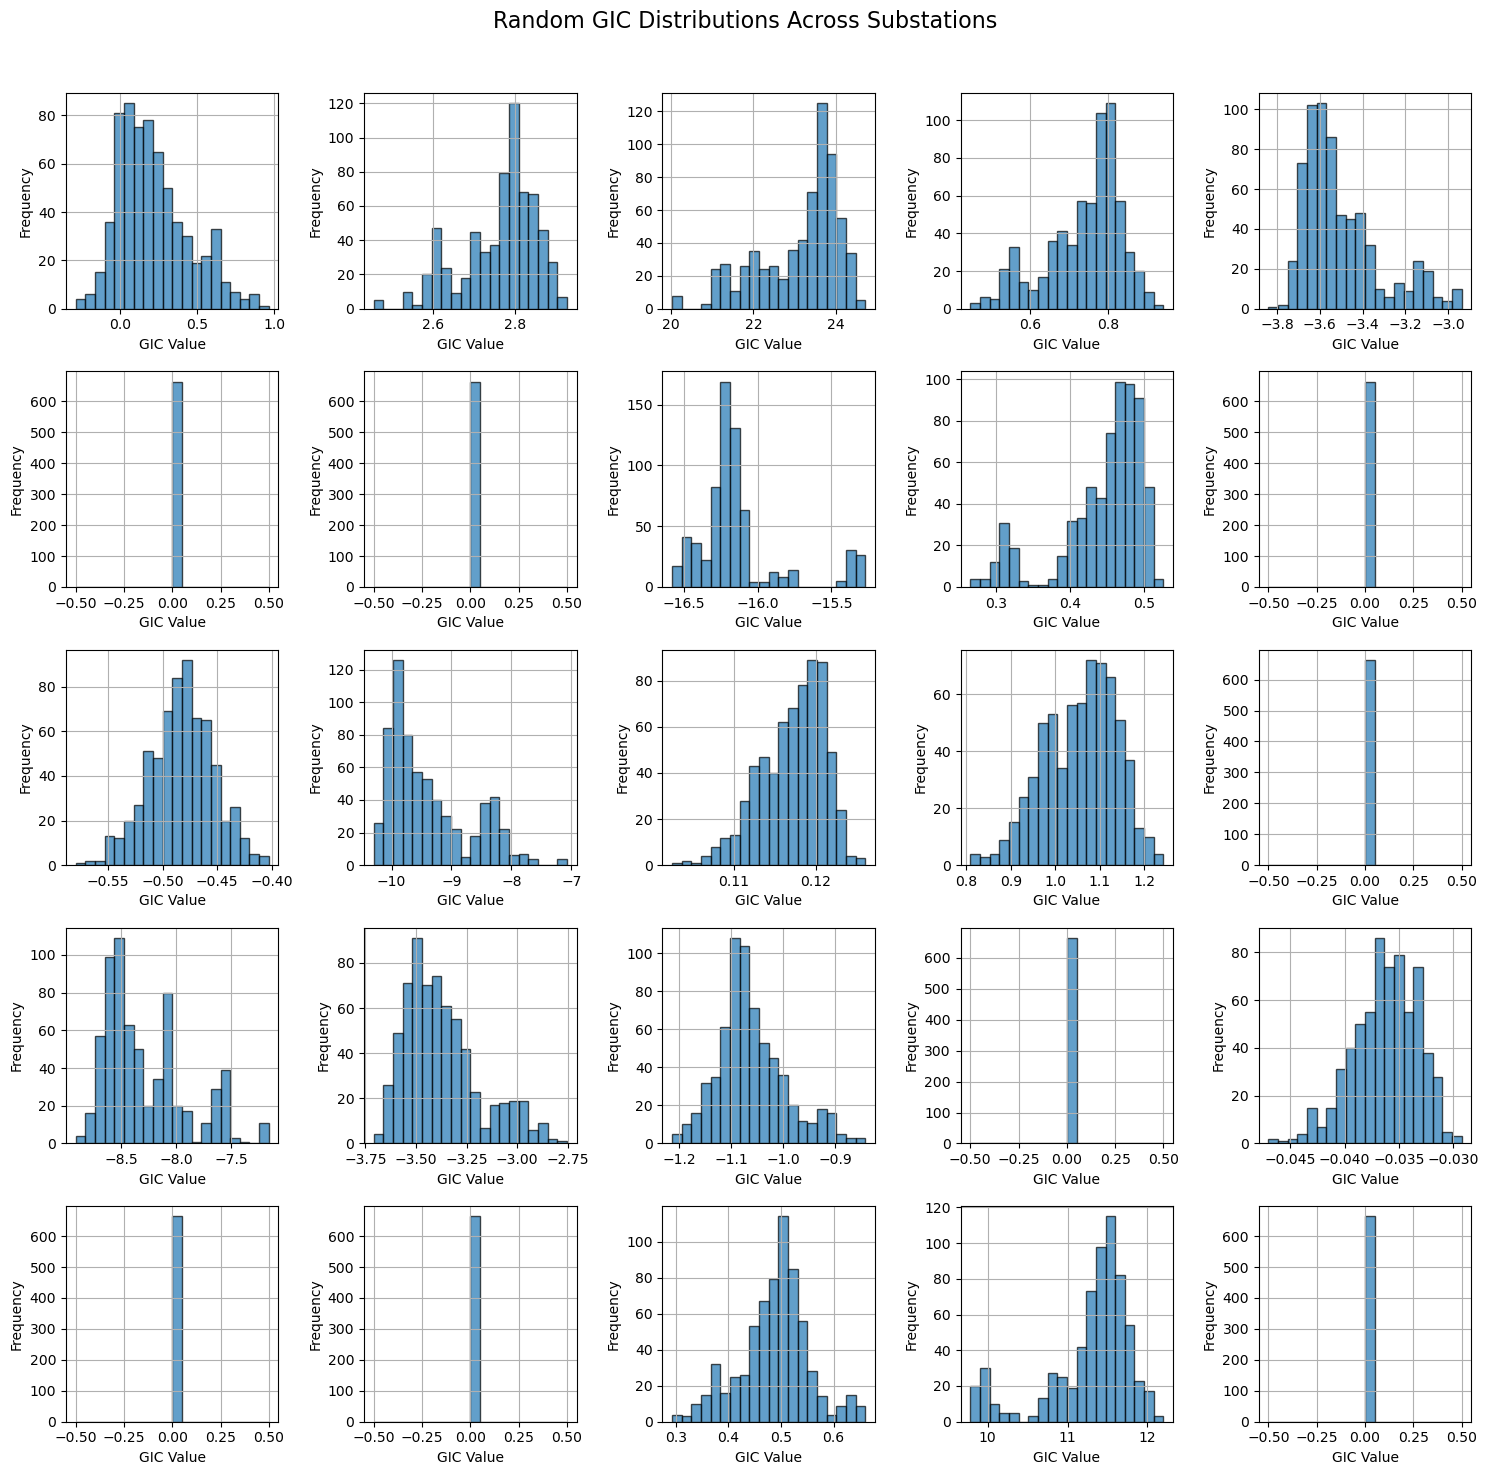

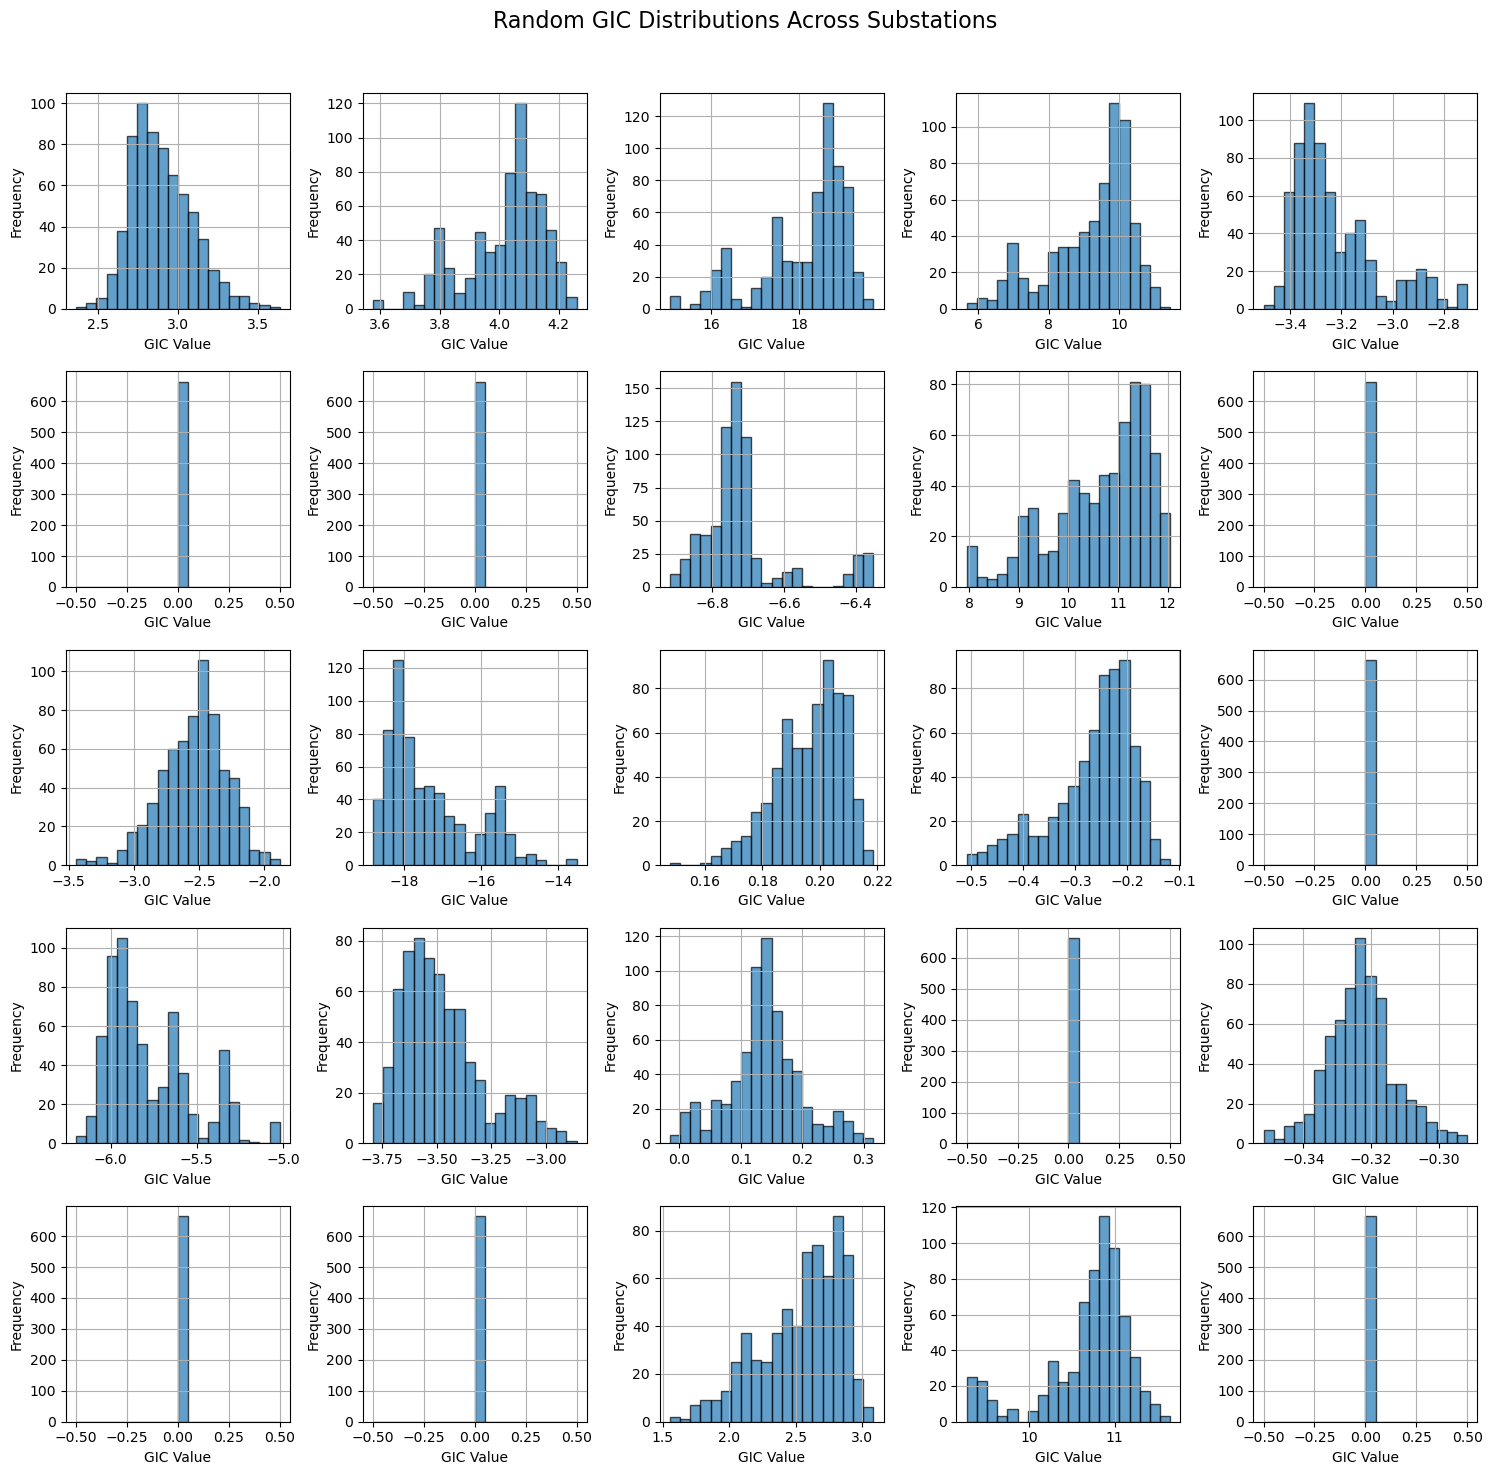

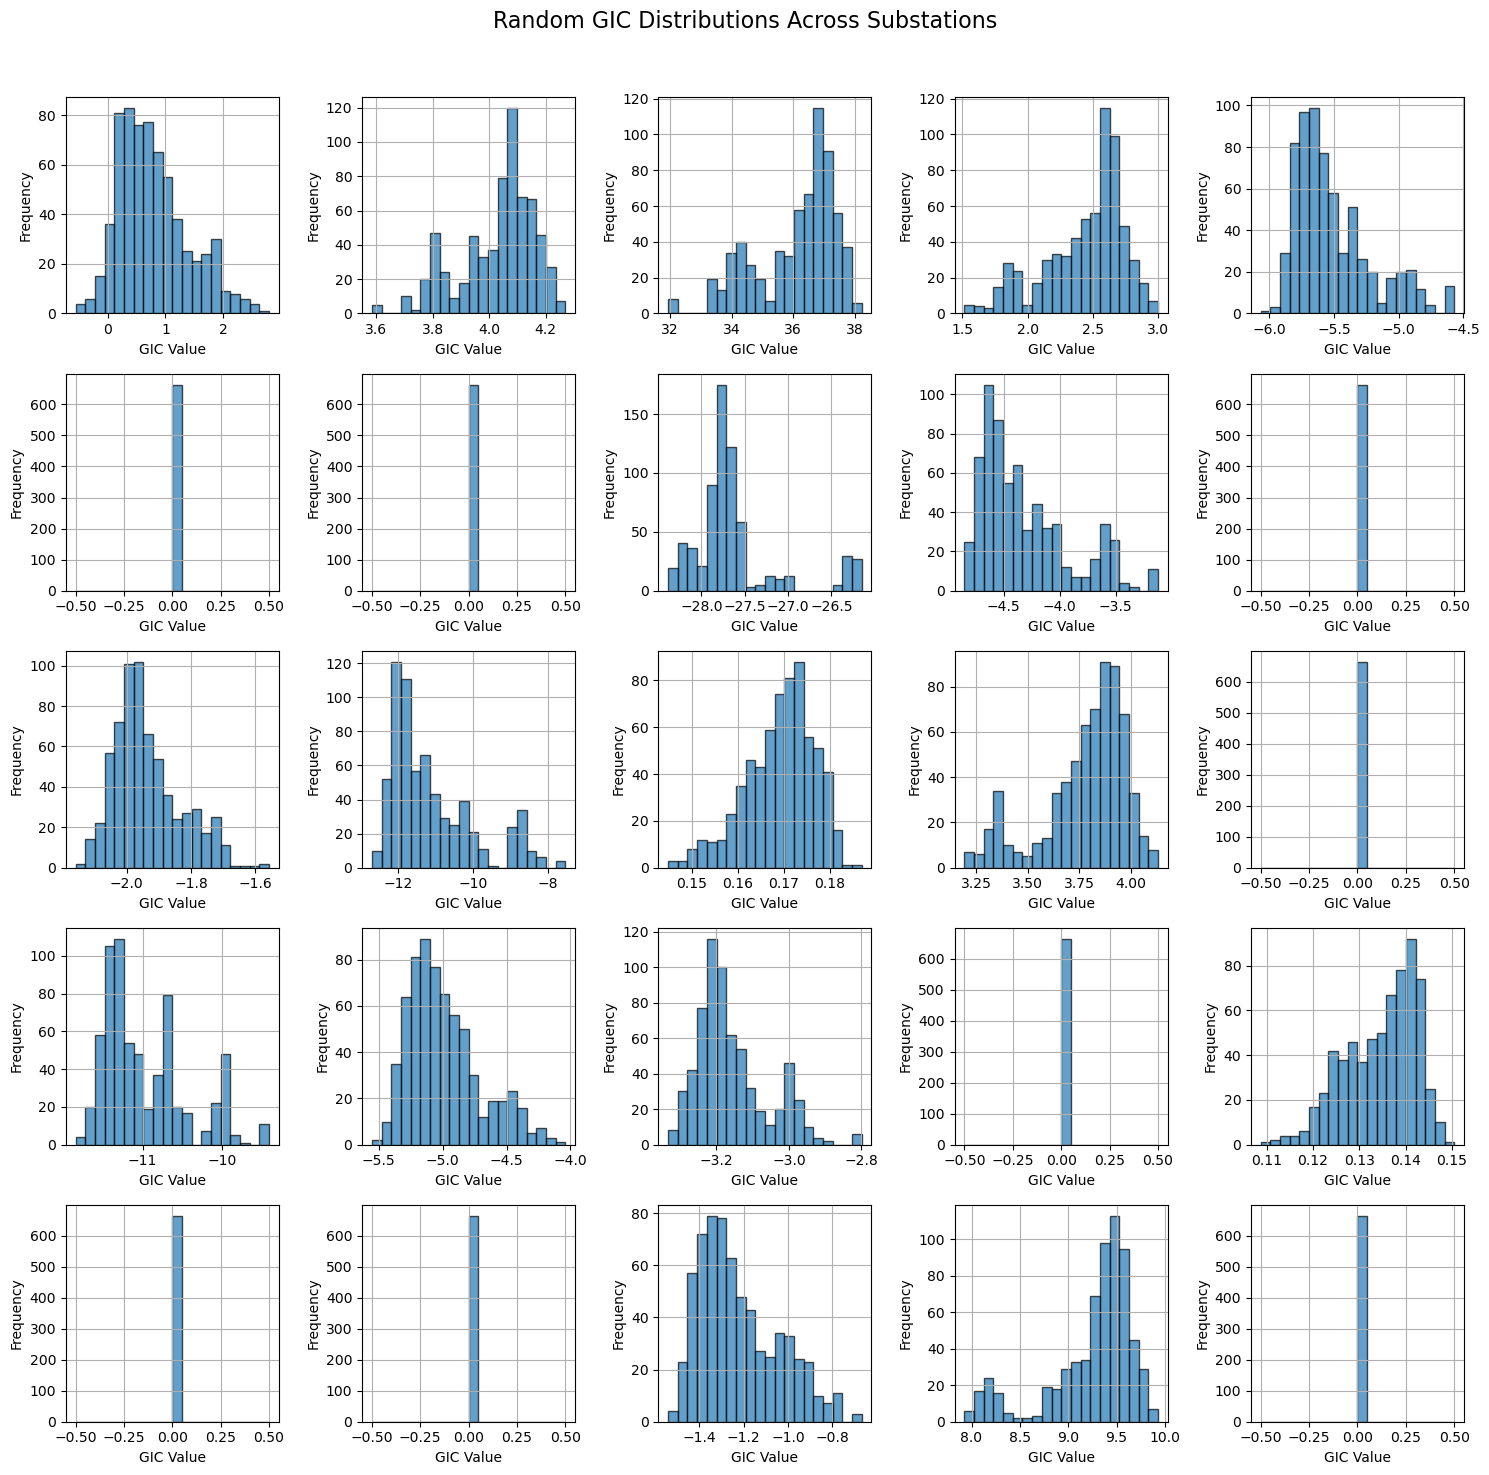

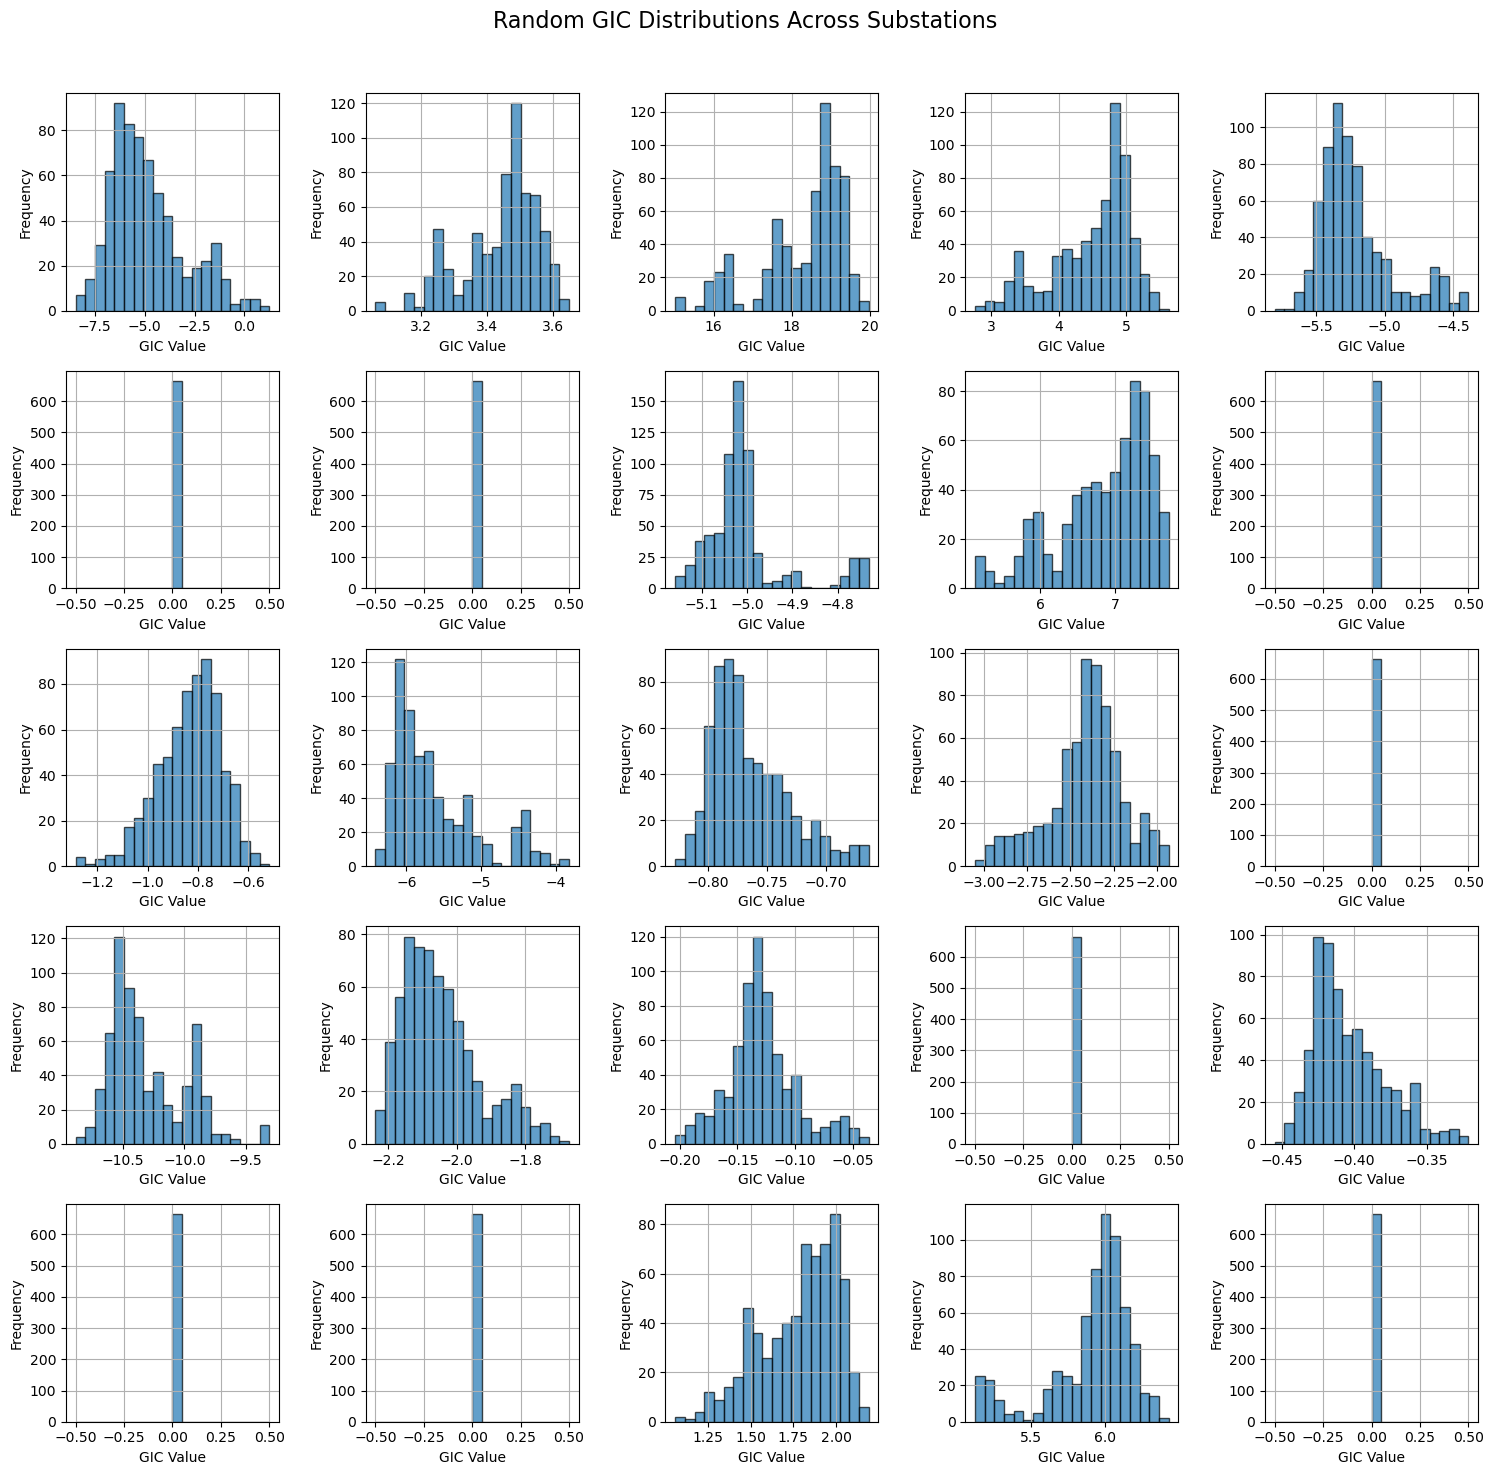

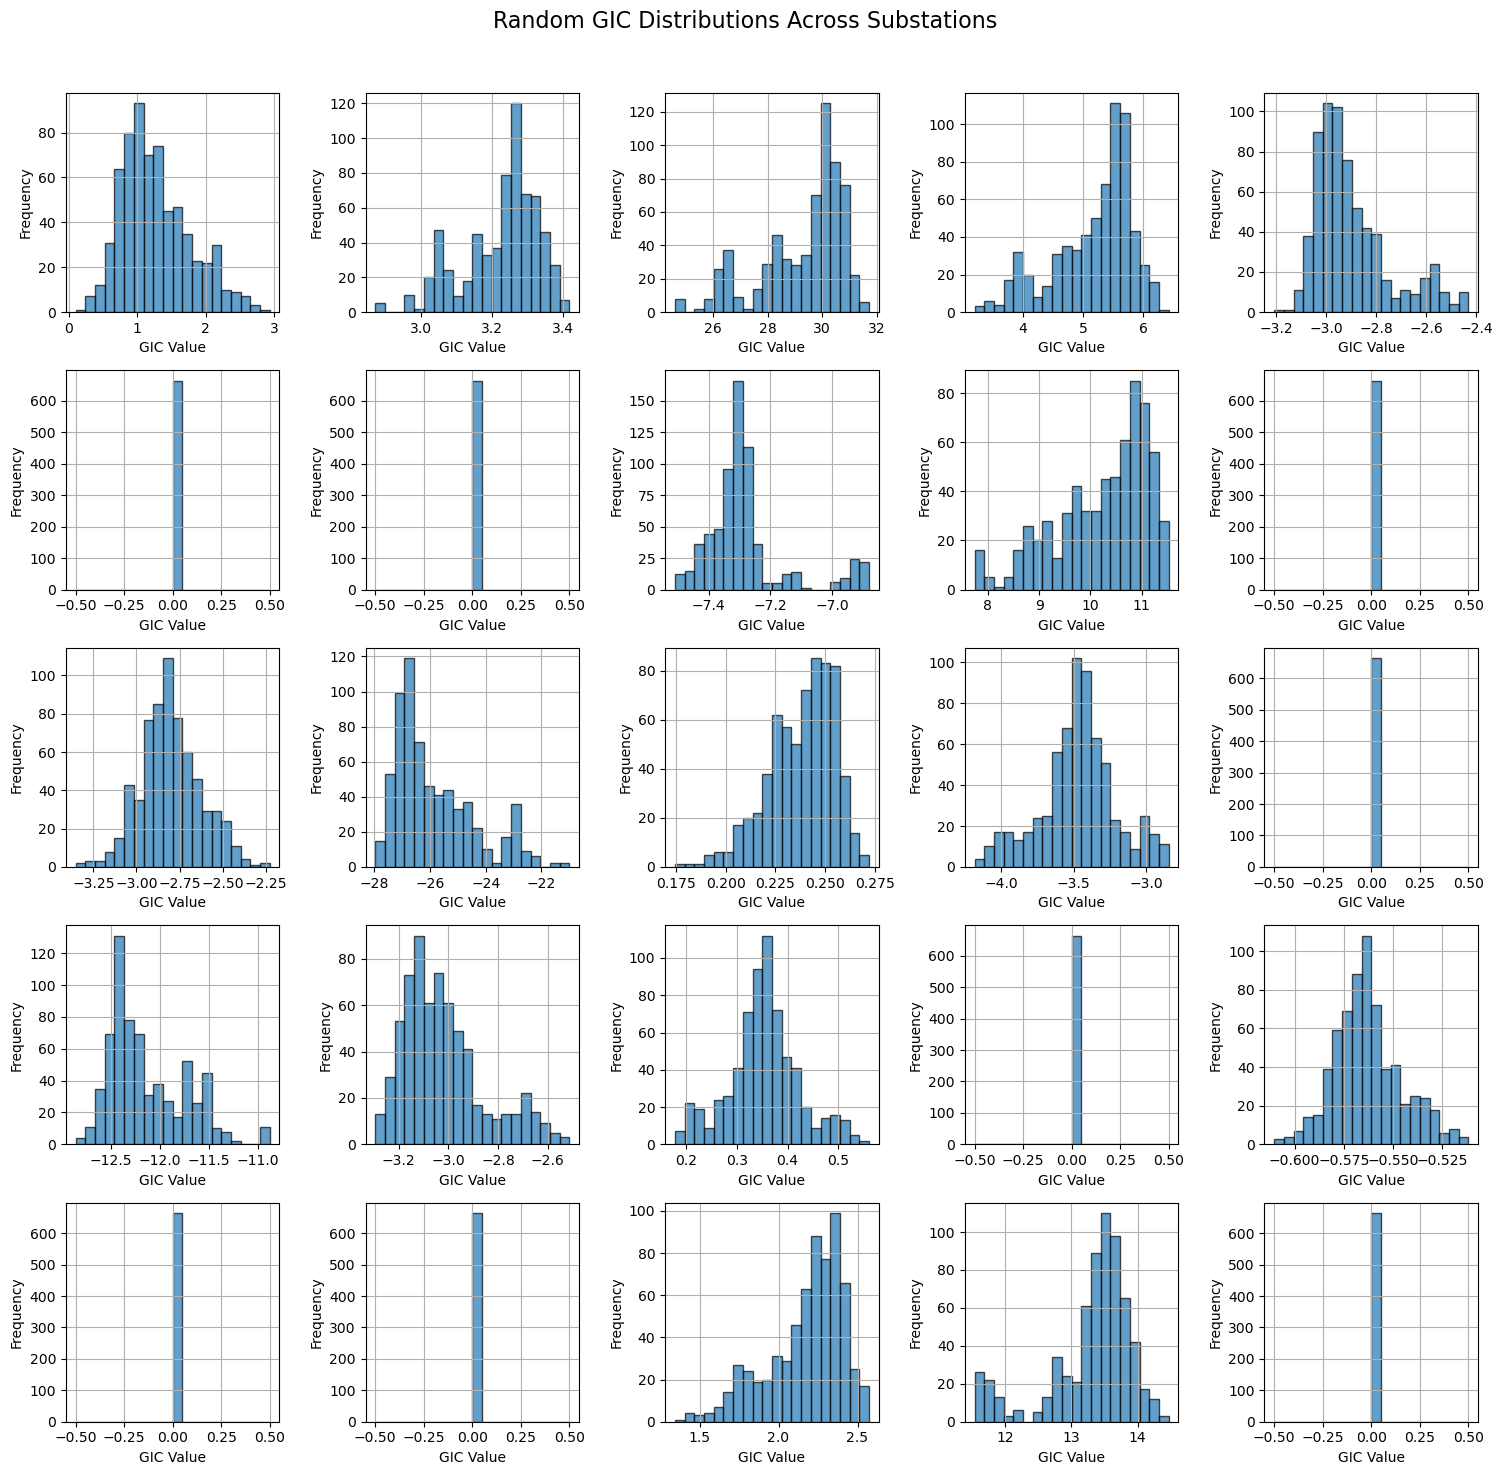

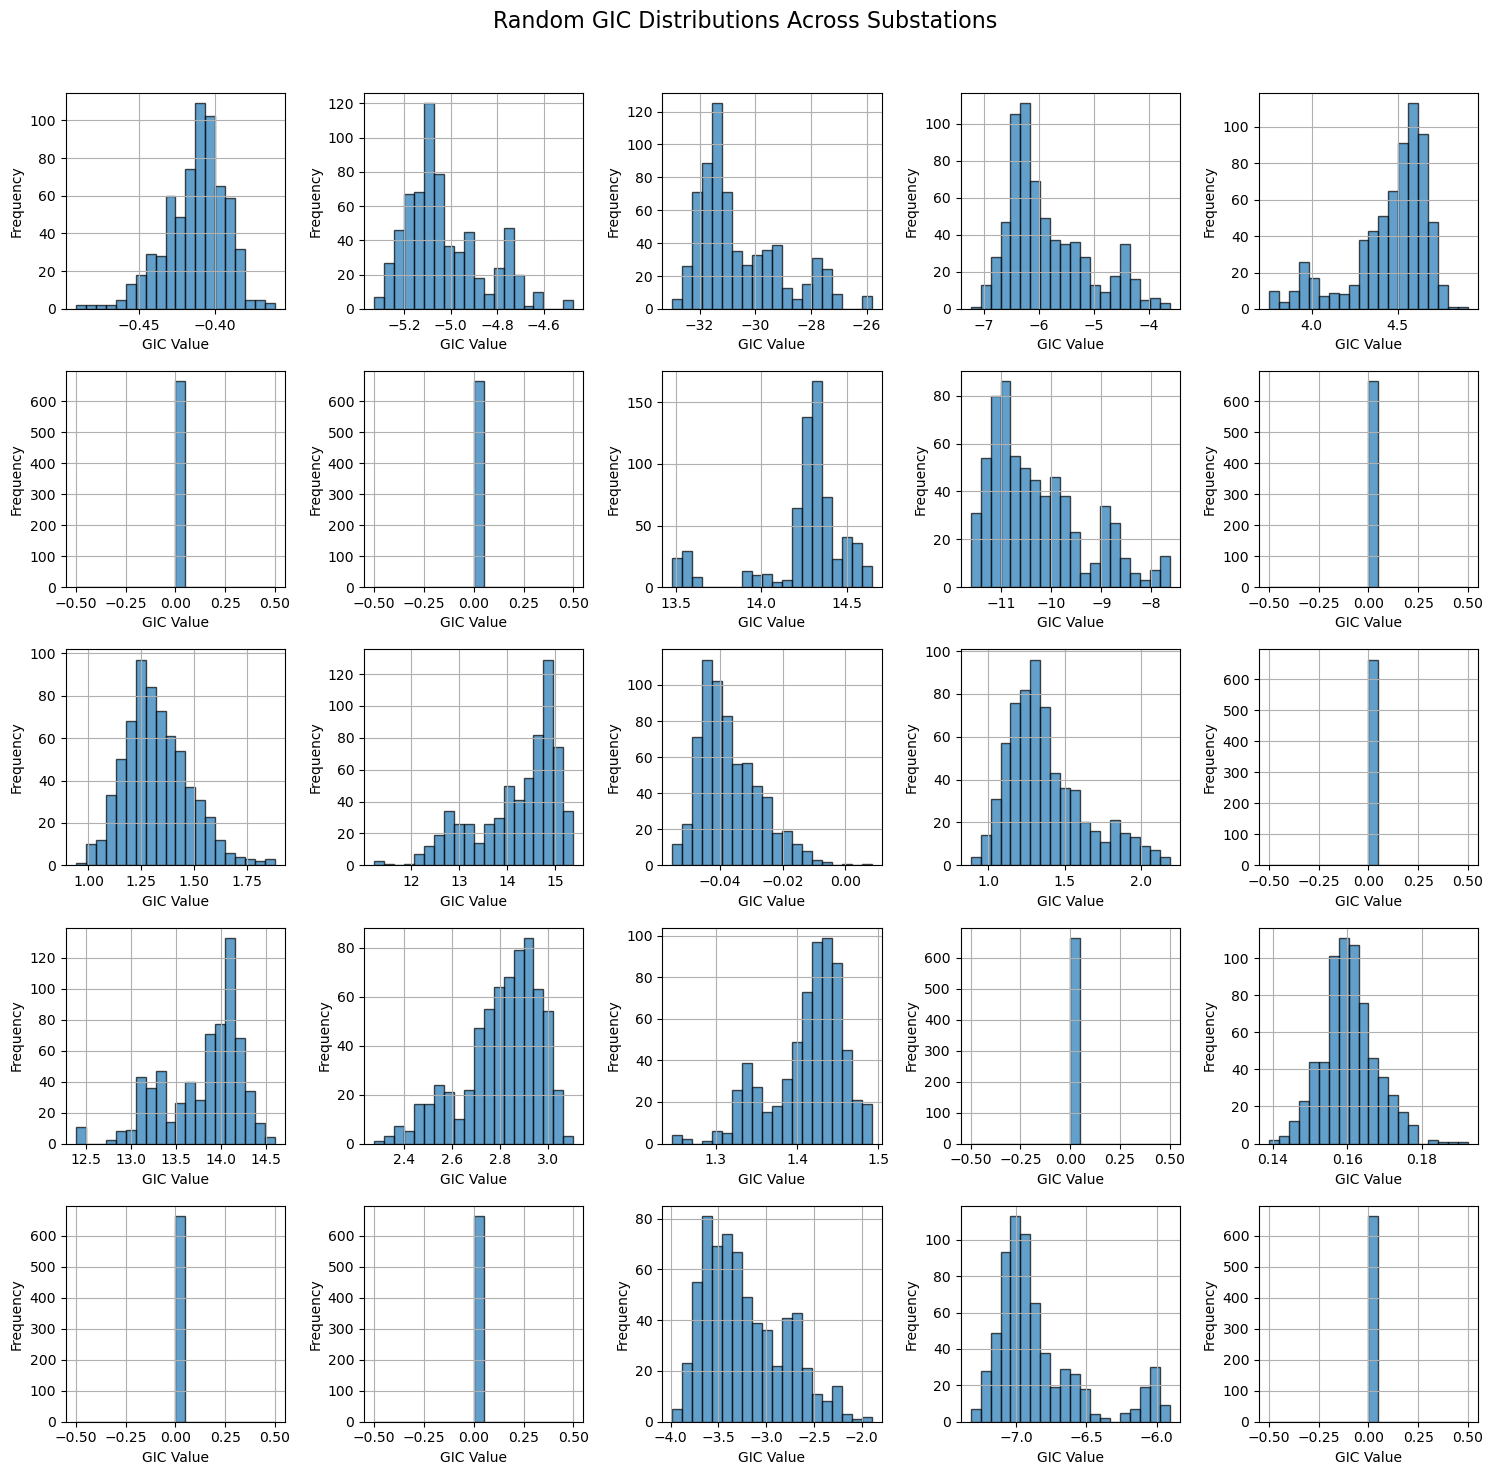

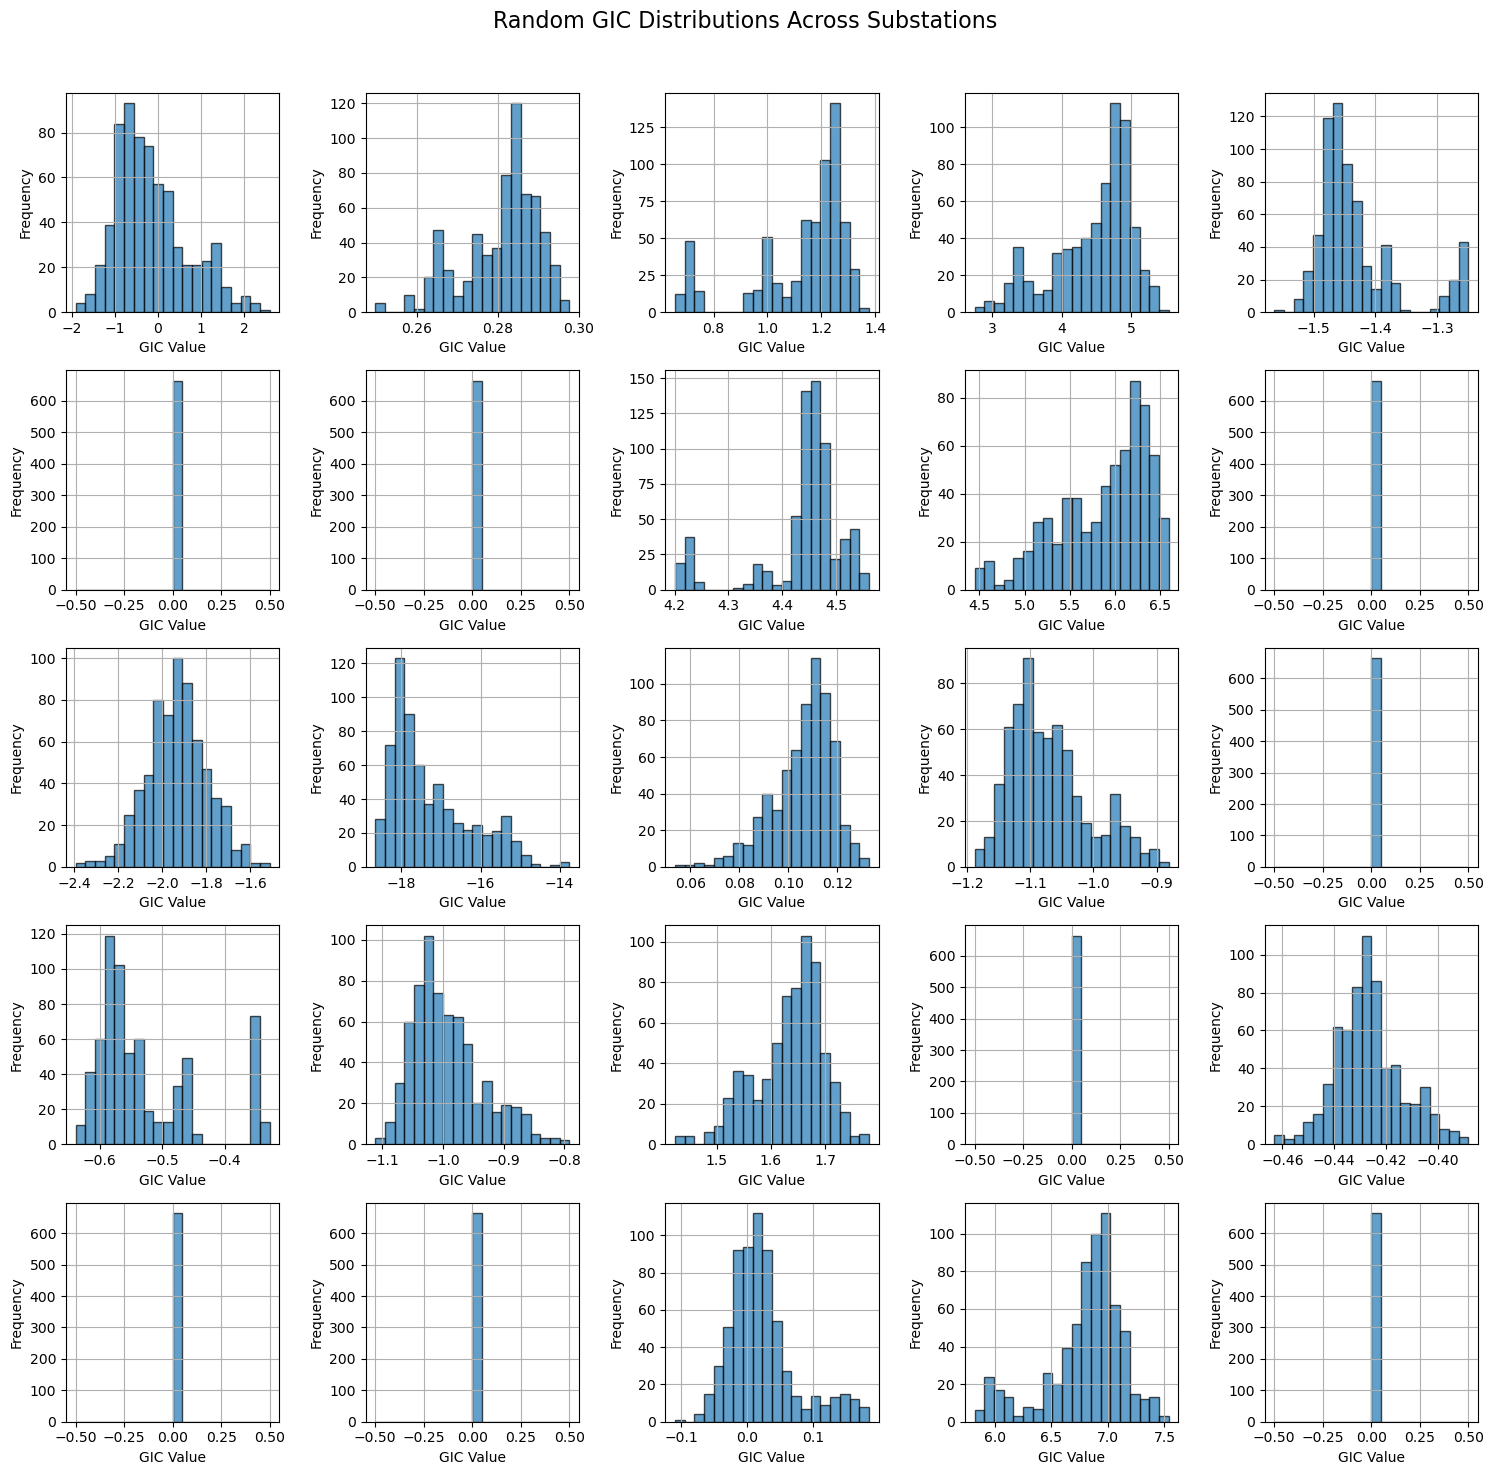

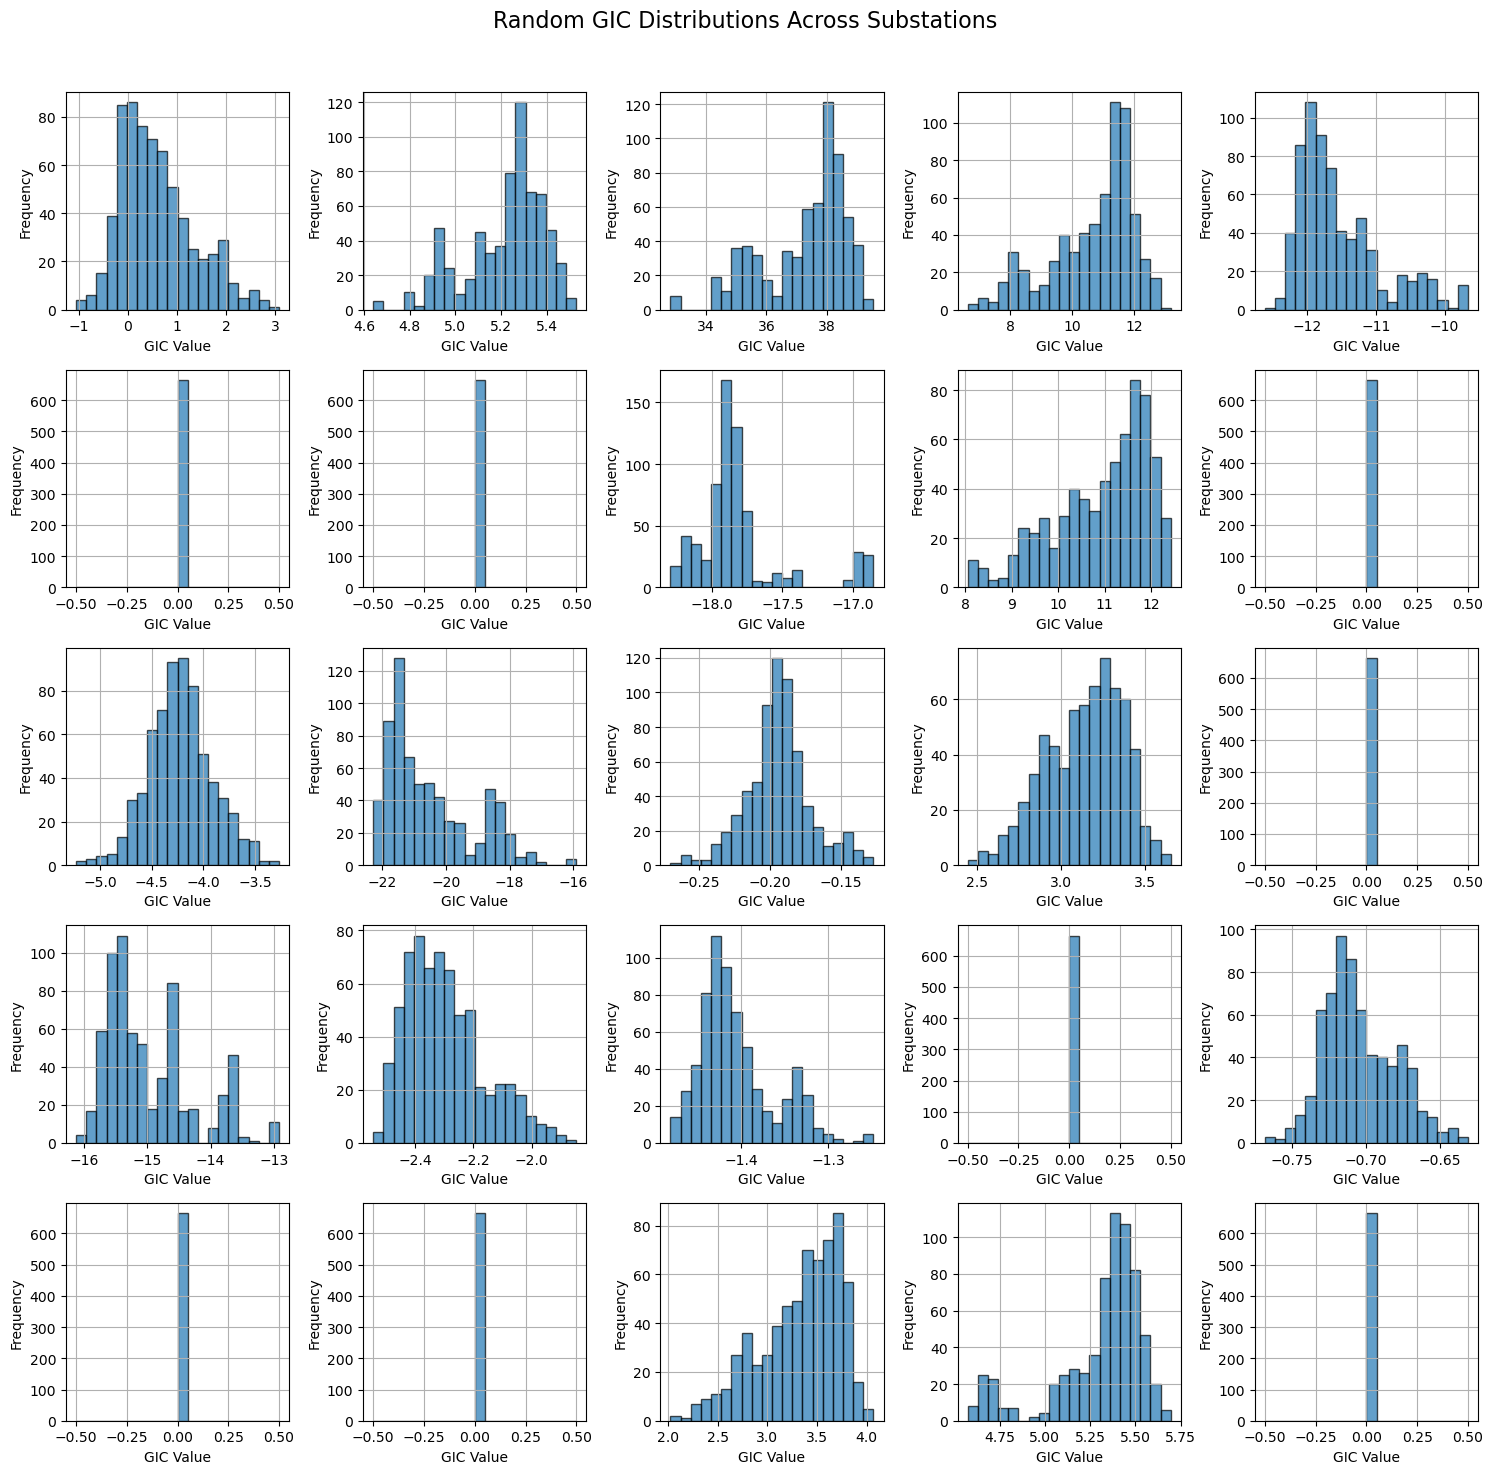

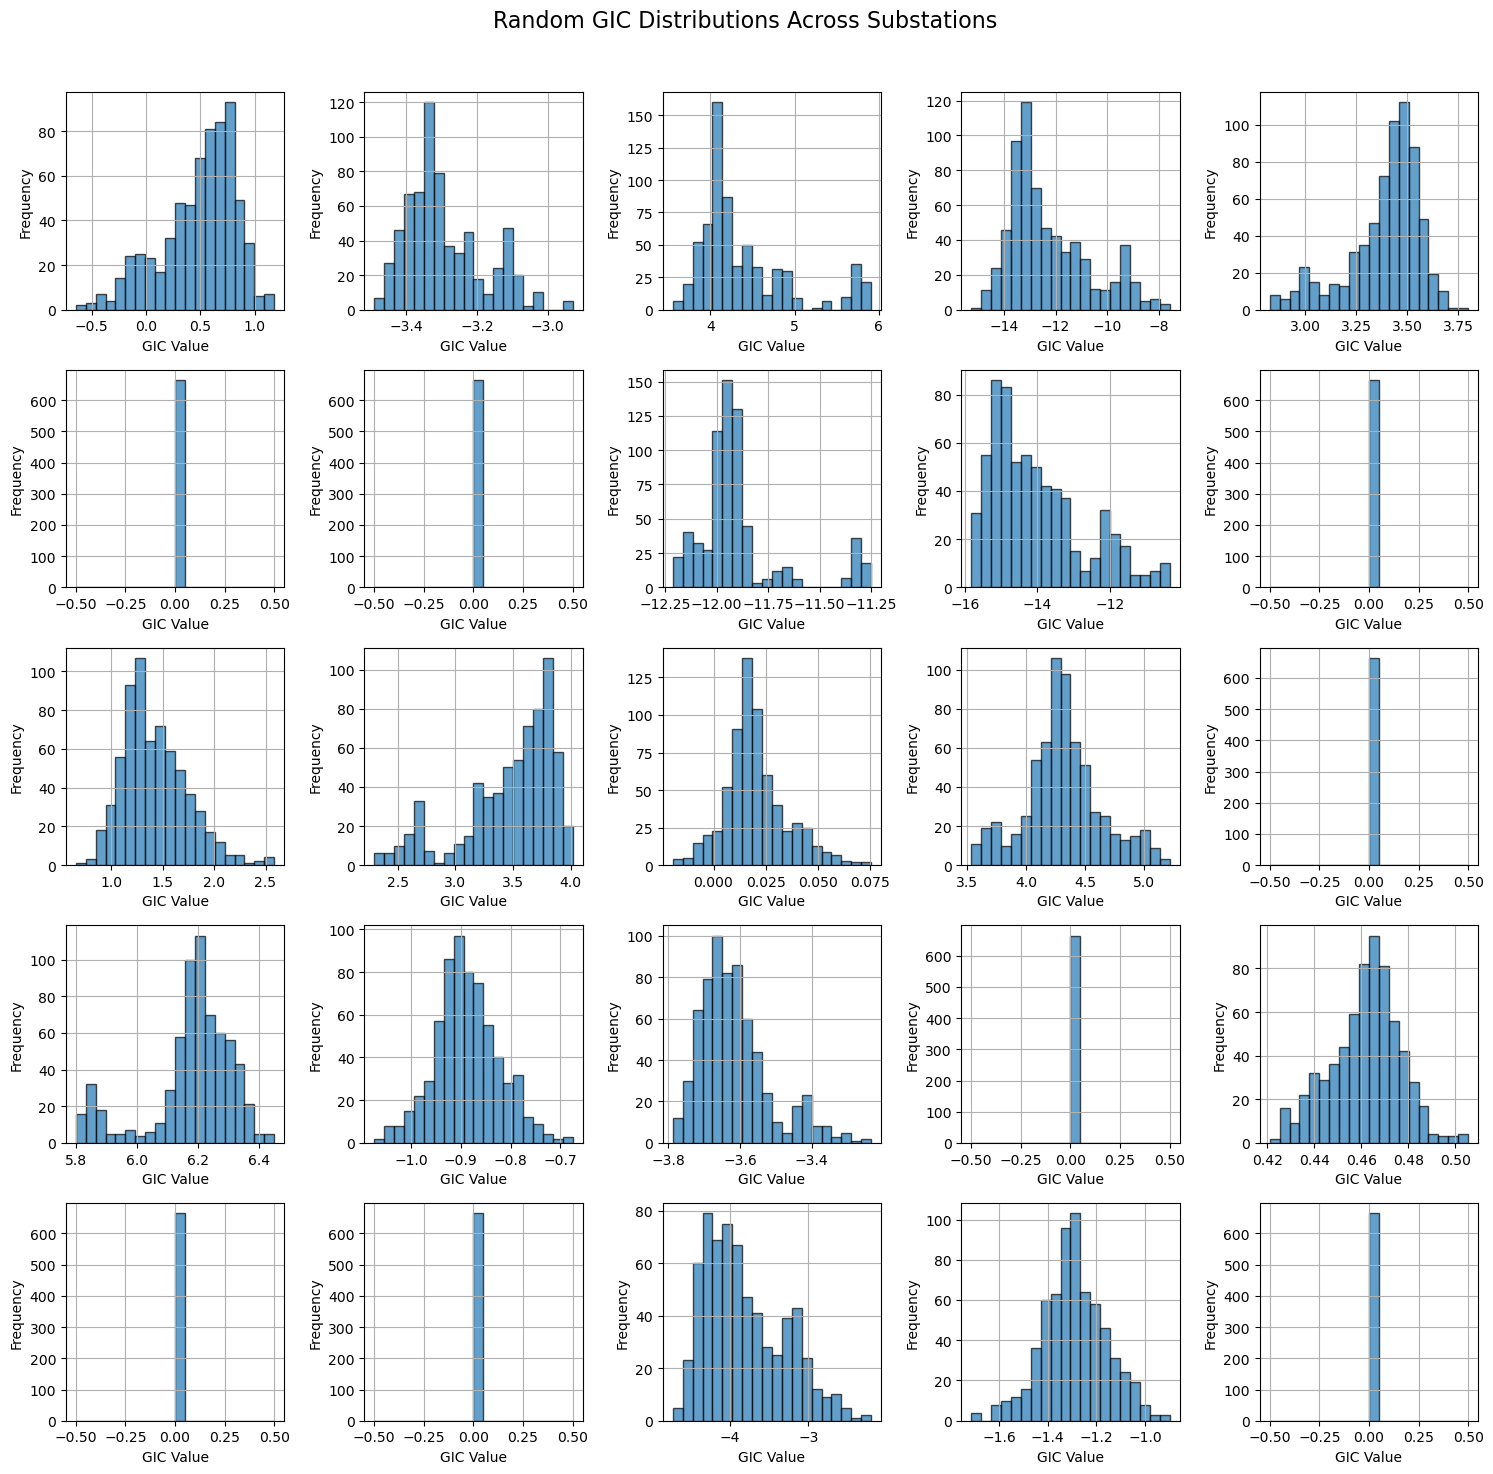

In [16]:
# Panel random 25
num_panels = 25
random_indices = np.random.choice(
    data_array.shape[1], min(num_panels, data_array.shape[1]), replace=False
)

for i in range(data_array.shape[2]):
    # Create a 5x5 subplot
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    fig.suptitle("Random GIC Distributions Across Substations", fontsize=16)
    
    for ax, idx in zip(axes.flatten(), random_indices):
        selected_row = data_array[:, idx, i]  # Exclude "Substation" column
        ax.hist(selected_row, bins=20, alpha=0.7, edgecolor="black")
        # ax.set_title(f"{merged_gic_df.iloc[idx, 0]}")
        ax.set_xlabel("GIC Value")
        ax.set_ylabel("Frequency")
        ax.grid(True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.show()

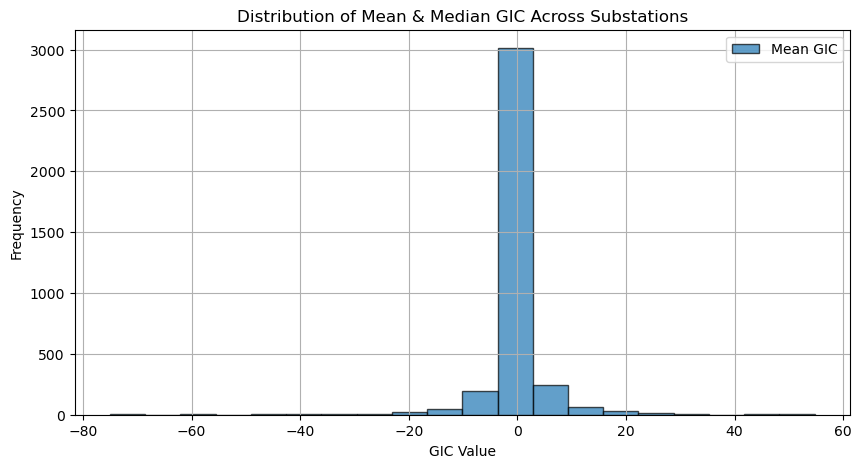

In [17]:
mean_values = np.mean(data_array, axis=0)  # Shape: (num_substations, num_timesteps)
median_values = np.median(data_array, axis=0)

plt.figure(figsize=(10, 5))

# Histogram of mean GIC values
plt.hist(
    mean_values[:, 11], bins=20, alpha=0.7, label="Mean GIC", edgecolor="black"
)

# # Histogram of median GIC values
# plt.hist(
#     median_values[:, 11],
#     bins=20,
#     alpha=0.7,
#     label="Median GIC",
#     edgecolor="black",
# )

plt.xlabel("GIC Value")
plt.ylabel("Frequency")
plt.title("Distribution of Mean & Median GIC Across Substations")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Remove duplicate substations
unique_substations = matches_df.drop_duplicates(subset=["substation"])
dropped_substations = matches_df[~matches_df.index.isin(unique_substations.index)]

# Remove duplicate monitoring sites
unique_sites = unique_substations.drop_duplicates(subset=["monitor_name"])
dropped_sites = unique_substations[~unique_substations.index.isin(unique_sites.index)]

# Get the remaining cleaned dataset
cleaned_df = unique_sites.copy()

# Save dropped duplicates for reference
dropped_duplicates_df = pd.concat([dropped_substations, dropped_sites])

matching_substations = cleaned_df["substation"].values
matching_sites = cleaned_df["monitor_name"].values

In [29]:
sample_df = pd.read_csv(gnd_files[0])
substation_names = sample_df["Substation"].values

substation_indices = [np.where(substation_names == sub)[0][0] for sub in matching_substations if sub in substation_names]

mean_simulated = median_values[substation_indices, 1:]
median_simulated = median_values[substation_indices, 1:]

In [32]:
# Initialize correctly
gic_realtime = np.zeros((len(matching_sites), peak_times.shape[0]))

for time_idx, time in enumerate(peak_times):
    gic_peak_values = np.zeros(len(matching_sites))  # Holds GIC values for this timestep
    
    for i, monitor_site in enumerate(matching_sites):
        gic_val = ds.gic.sel(time=time, device=monitor_site).values  # Use correct time variable
        gic_peak_values[i] = gic_val.ravel()[0]  # Ensure single value extraction
    
    gic_realtime[:, time_idx] = gic_peak_values  # Assign to the correct array

print("GIC Realtime Shape:", gic_realtime.shape)  # Expected: (num_timesteps, num_sites)


GIC Realtime Shape: (170, 19)


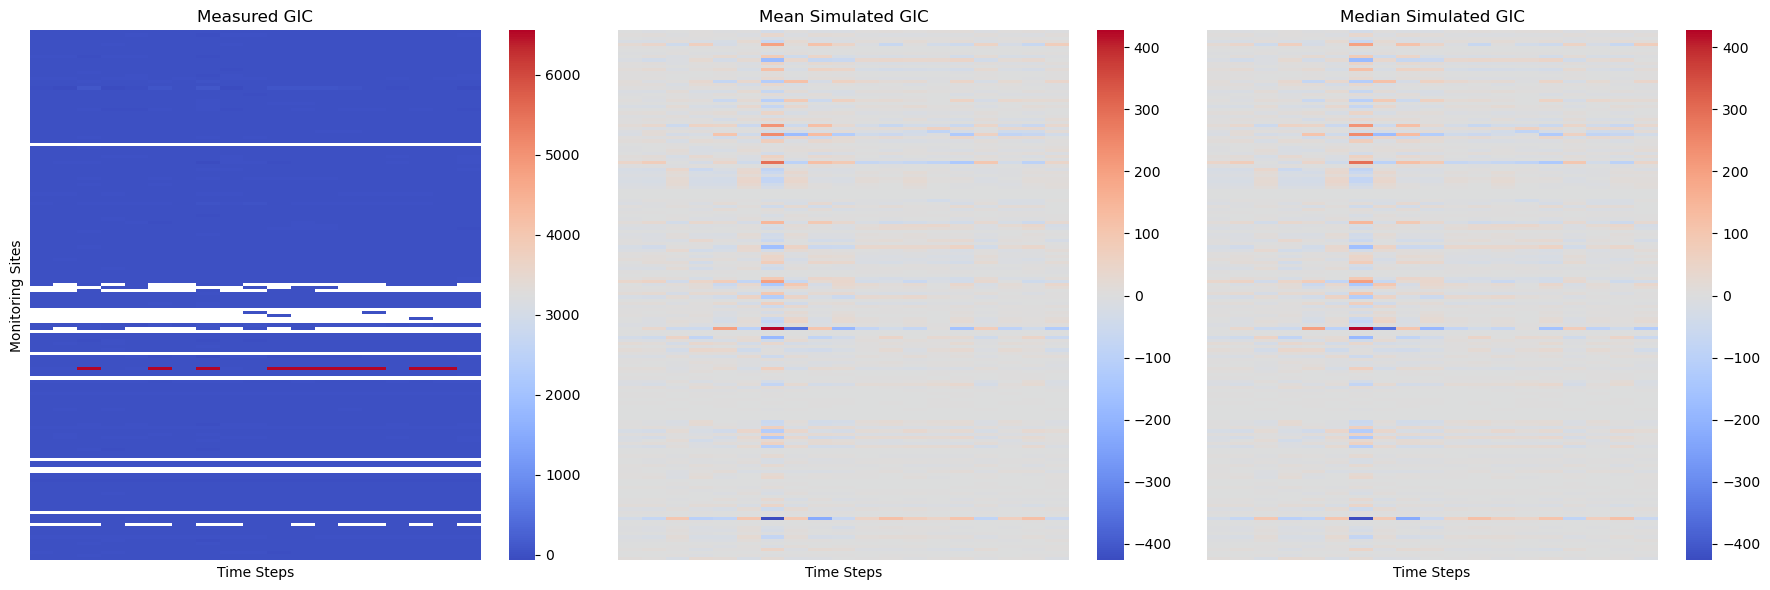

In [34]:
# Set up the figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Heatmap for Measured GIC
sns.heatmap(gic_realtime, ax=axes[0], cmap="coolwarm", xticklabels=False, yticklabels=matching_sites)
axes[0].set_title("Measured GIC")
axes[0].set_xlabel("Time Steps")
axes[0].set_ylabel("Monitoring Sites")

# Heatmap for Mean Simulated GIC
sns.heatmap(mean_simulated, ax=axes[1], cmap="coolwarm", xticklabels=False, yticklabels=False)
axes[1].set_title("Mean Simulated GIC")
axes[1].set_xlabel("Time Steps")

# Heatmap for Median Simulated GIC
sns.heatmap(median_simulated, ax=axes[2], cmap="coolwarm", xticklabels=False, yticklabels=False)
axes[2].set_title("Median Simulated GIC")
axes[2].set_xlabel("Time Steps")

plt.tight_layout()
plt.show()


In [45]:
np.nanmax(gic_realtime[:,5])

6531.0

(array([ 2.,  0.,  4., 11., 86., 48., 17.,  1.,  0.,  1.]),
 array([-95.91172218, -76.18193626, -56.45215034, -36.72236443,
        -16.99257851,   2.73720741,  22.46699333,  42.19677925,
         61.92656517,  81.65635109, 101.38613701]),
 <BarContainer object of 10 artists>)

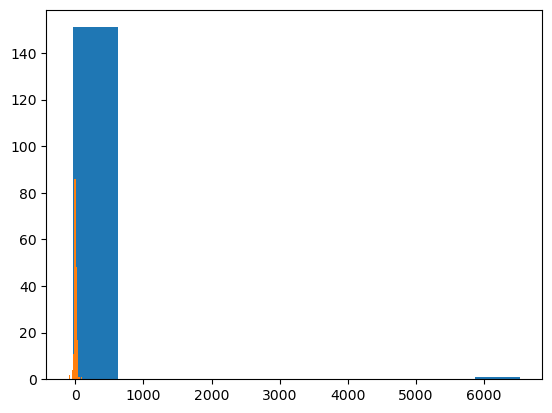

In [49]:
plt.hist(gic_realtime[:,5])
plt.hist(median_simulated[:, 5])

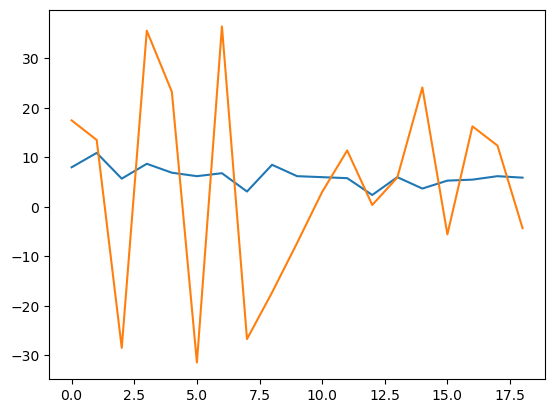

In [57]:
plt.plot(gic_realtime[100,:])
plt.plot(median_simulated[100, :])

In [ ]:

# # Find the correlations between the simulated and computed values
# from scipy.stats import pearsonr, spearmanr
# import seaborn as sns

# valid_indices = ~np.isnan(gic_peak_values) & ~np.isnan(gannon_sim_values)

# # Filter both arrays to remove NaNs
# gic_peak_values_clean = gic_peak_values[valid_indices]
# gannon_sim_values_clean = gannon_sim_values[valid_indices]

# plt.figure(figsize=(10, 5))
# plt.hist(gic_peak_values_clean, bins=20, alpha=0.6, label="Observed GIC")
# plt.hist(gannon_sim_values_clean, bins=20, alpha=0.6, label="Simulated GIC")
# plt.xlabel("GIC Value")
# plt.ylabel("Frequency")
# plt.legend()
# plt.title("Comparison of Observed vs Simulated GIC Distributions")
# plt.grid(True)
# plt.show()
# # %%
# import matplotlib.gridspec as gridspec
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature


# # Set up map
# def setup_map(ax, spatial_extent=[-120, -75, 25, 50]):
#     ax.set_extent(spatial_extent, ccrs.PlateCarree())

#     ax.add_feature(cfeature.LAND, facecolor="#F0F0F0")
#     ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor="grey")
#     ax.add_feature(cfeature.STATES, linewidth=0.4, edgecolor="#E6F3FF")
#     ax.add_feature(cfeature.LAKES, alpha=0.5, linewidth=0.5, edgecolor="grey")

#     gl = ax.gridlines(
#         draw_labels=False, linewidth=0.2, color="grey", alpha=0.5, linestyle="--"
#     )

#     return ax


# # Simulated GIC GeoDataFrame
# sim_gdf = gpd.GeoDataFrame(
#     cleaned_df[["substation", "gannon_sim"]],
#     geometry=[
#         Point(lon, lat)
#         for lon, lat in zip(cleaned_df["sub_lon"], cleaned_df["sub_lat"])
#     ],
# )

# # Measured GIC GeoDataFrame
# real_gdf = gpd.GeoDataFrame(
#     cleaned_df[["monitor_name", "gic_peak_measured"]],
#     geometry=[
#         Point(lon, lat)
#         for lon, lat in zip(cleaned_df["monitor_lon"], cleaned_df["monitor_lat"])
#     ],
# )

# # Plot
# fig = plt.figure(figsize=(15, 8))
# ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
# ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())

# ax1 = setup_map(ax1)
# ax2 = setup_map(ax2)

# # Plot simulated GIC
# sim_gdf.plot(
#     ax=ax1, color="red", alpha=0.5, markersize=np.abs(sim_gdf["gannon_sim"]) * 5
# )
# ax1.set_title("Simulated GIC")

# # Plot measured GIC
# real_gdf.plot(
#     ax=ax2,
#     color="blue",
#     alpha=0.5,
#     markersize=np.abs(real_gdf["gic_peak_measured"]) * 5,
# )
# ax2.set_title("Measured GIC")

# for ax in [ax1, ax2]:
#     ax.set_xlabel("Longitude")
#     ax.set_ylabel("Latitude")

# # %%
